<small>
<pre style=" font-size: smaller;">
                                                (@@@)     (@@@@@)
                                           (@@)     (@@@@@@@)        (@@@@@@@)
                                     (@@@@@@@)   (@@@@@)       (@@@@@@@@@@@)
                                (@@@)     (@@@@@@@)   (@@@@@@)             (@@@)
                           (@@@@@@)    (@@@@@@)                (@)
                       (@@@)  (@@@@)           (@@)
                    (@@)              (@@@)
                   .-.               
                   ] [    .-.      _    .-----.
                 ."   """"   """""" """"| .--`
                (:--:--:--:--:--:--:--:-| [___    .------------------------.
                 |C&O  :  :  :  :  :  : [_9_] |'='|.----------------------.|
                /|.___________________________|___|'--.___.--.___.--.___.-'| 
               / ||_.--.______.--.______.--._ |---\'--\-.-/==\-.-/==\-.-/-'/--
              /__;^=(==)======(==)======(==)=^~^^^ ^^^^(-)^^^^(-)^^^^(-)^^^ jgs
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
</pre>
</small>
<h1 style="text-align: center; font-size: 60px;">Process CE Data</h1>

## Properties for successful signal analysis
 - Each peak is defined by the following properties:
    - Peak position (identifies each chemical)
    - Peak area (determines compound concentration)
## Requirements for successful signal analysis
 - Need to identify standard peak, such as PABA within the signal (retention time, peak area)
 - Need to normalise peak retention time such that chemicals can be identified
 - Need to normalise absorptions such that compound concentrations can be compared

## To Do
 - Get list of 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks,peak_widths
from scipy.integrate import trapz
from pybaselines import whittaker

In [2]:
experiment_folder = "../../../data/CE_data/17_01_24_0.5mM_pNPS/"
peaks_to_identify = {
    "PABA":{"lower_retention_time":2000, "upper_retention_time":4000},
    "pNPS":{"lower_retention_time":3500,"upper_retention_time":6000, "PABA_proportionality":1.28,"proportionality_tolerance":0.2},
    "PAPA":{"lower_retention_time":4800,"upper_retention_time":10000, "PABA_proportionality":2.61,"proportionality_tolerance":0.4}
}

In [3]:
def load_chromatography_data(filepath):
    # Create an empty dictionary to store the data
    data = {}

    # List all files in the directory
    for filename in os.listdir(filepath):
        # Check if the file is a text file
        if filename.endswith('.txt'):
            # Construct the full file path
            file_path = os.path.join(filepath, filename)
            
            # Load the file into a NumPy array
            array = np.loadtxt(file_path, delimiter=',')
            
            # Extract the well position from the filename (e.g., A1, B2, etc.)
            well_position = filename.split('.')[0]
            
            # Add the NumPy array to the dictionary
            data[well_position] = array

    return data

def get_baseline(x,y):
    lam_equation = lambda n: 10**(-6.35 + np.log10(n) * 4.17)
    
    lam = lam_equation(len(x))
    baseline, params = whittaker.asls(y, lam=lam/10000, tol=-1, max_iter=8)

    mean_diff = np.mean(y - baseline)
    
    normalized_baseline = baseline + mean_diff
    
    return normalized_baseline

def draw_peak_grid(processed_data):
    # Create an empty grid to represent the wells
    grid = np.full((8, 12), -2, dtype=int)  # Assuming 8 rows (A-H) and 12 columns (1-12)
    
    for key, chromatogram in processed_data.items():
        # Extract the row and column indices from the key (e.g., 'A1' => row=0, col=0)
        row = ord(key[0]) - ord('A')
        col = int(key[1:]) - 1  # Subtract 1 because 1-based indexing
        
        # Check if peaks were found in this well
        if (chromatogram["column_status"] == "bad"):
            grid[row, col] = -1 
            continue
        grid[row, col] = len(chromatogram["peaks"])  
    
    # Create a grid plot with orange color
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap='Oranges', interpolation='none', aspect='equal')
    plt.xticks(np.arange(12), np.arange(1, 13))  # Label the columns as 1 to 12
    plt.yticks(np.arange(8), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])  # Label the rows as A to H
    plt.xlabel('Well Column')
    plt.ylabel('Well Row')
    plt.title('Peak Detection Grid (Orange Color)')
    
    # Add text labels indicating presence or absence of peaks
    for i in range(8):
        for j in range(12):
            plt.text(j, i, str(grid[i, j]), va='center', ha='center', fontsize=12, color='white' if grid[i, j] == 0 else 'black')

    plt.colorbar(label='Peak Found (1) or Not Found (0)')
    plt.show()
def analyze_chromatogram(x, y, prominence=4, width=20, rel_height=0.8, compounds_to_identify = ["pNPS","PAPA"]):
    # Find the peaks in the chromatography data
    peaks, properties = find_peaks(y, prominence=prominence, width=width)
    #Validate peaks here before sending data back
    if(len(peaks) > 5):
        return "bad",[]
    if(len(peaks) < 1): #We always need at least 1 peak
        return "bad",[]
    # Calculate peak widths
    results_half = peak_widths(y, peaks, rel_height=rel_height)

    peaks_with_info = []
    identified_compounds = []
    for i in range(len(peaks)):
        peak_index = peaks[i]
        left_ips = int(results_half[2][i])
        right_ips = int(results_half[3][i])
        peak_x = x[peak_index]
        peak_y = y[peak_index]
        if peak_x < 1500:
            continue
        # Calculate the integral of the peak (assuming evenly spaced data)
        peak_integral = trapz(y[left_ips:right_ips], x[left_ips:right_ips])
   
        # Store peak information in a dictionary
        peak_info = {
            "peak_position": peak_x,
            "peak_boundaries": (x[left_ips], x[right_ips]),
            "peak_maximum": peak_y,
            "peak_area": peak_integral,
            "compound":"unknown"
        }
        peaks_with_info.append(peak_info)


    #Identify important compounds in peaks
    peaks_sorted_by_size = sorted(peaks_with_info, key=lambda peak: peak['peak_area'], reverse=True)
    #Identify PABA 
    PABA_candidates = peaks_sorted_by_size[0:3]
    PABA_candidates_sorted_by_position = sorted(PABA_candidates, key=lambda peak: peak['peak_position'])
    PABA_info = peaks_to_identify["PABA"]
    PABA_peak = None
    for candidate in PABA_candidates_sorted_by_position:
        if(candidate["peak_position"] > PABA_info["lower_retention_time"] and candidate["peak_position"] < PABA_info["upper_retention_time"]):
            PABA_peak = candidate
            PABA_peak["compound"] = "PABA"
            peaks_with_info = [d for d in peaks_with_info if d != PABA_peak]
            break
    if (not PABA_peak):
        return "bad",[]

    #Identify other compound peaks
    identified_compounds = []
    for compound_to_identify in compounds_to_identify:
        if not peaks_with_info:
            break
        compound_info = peaks_to_identify[compound_to_identify]
        desired_proportional_ratio = compound_info["PABA_proportionality"]
        PABA_rt = PABA_peak["peak_position"]
        sort_func = lambda peak: abs(peak["peak_position"]/PABA_rt - desired_proportional_ratio)
        sorted_peaks = sorted(peaks_with_info, key=sort_func)
        if(sort_func(sorted_peaks[0]) < compound_info["proportionality_tolerance"]):
            sorted_peaks[0]["compound"] = compound_to_identify
            identified_compounds.append(sorted_peaks[0])
            peaks_with_info = sorted_peaks[1:]

            
    return "good",[PABA_peak] + identified_compounds + peaks_with_info

def process_chromatography_data(folder):
    data = load_chromatography_data(folder)
    processed_data = {}
    peaks = {}

    for key, data_array in data.items():

        processed_data[key] = {}
        x = data_array[:, 0]  # Extract time index x from the array
        y = data_array[:, 1]  # Extract the original y values
        if (not np.isfinite(y).all()):
            y = np.zeros(len(x))
            print(f"No data for well {key}, filling this position with empty data")
            
        processed_data[key]["x"] = x
        processed_data[key]["y"] = y
        
        # Apply the get_baseline function to obtain baseline-free data
        baseline_free_y = y - get_baseline(x, y)
        processed_data[key]["baseline_free_y"] = baseline_free_y
        # Analyze chromatogram and validate peaks
        column_status,chromatogram_peaks = analyze_chromatogram(x, baseline_free_y)
        
        peaks[key] = chromatogram_peaks
        processed_data[key]["column_status"] = column_status
        processed_data[key]["peaks"] = chromatogram_peaks
    
    return processed_data

def plot_chromatography_data(data):
    # Number of rows and columns for the subplot grid
    n_rows = 8  # For wells A to H
    n_cols = 12 # For wells 1 to 12

    # Create a figure with subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Iterate over the dictionary to plot each well's data
    for well_position, values in data.items():
        # Determine the row and column for the subplot
        row = ord(well_position[0]) - ord('A') # Convert 'A'-'H' to 0-7
        col = int(well_position[1:]) - 1       # Convert '1'-'12' to 0-11

        # Plot the data in the corresponding subplot
        axs[row, col].plot(values["x"], values["y"])
        if(well_position[0] == "A"):
            axs[row, col].set_title(well_position)
    
    plt.show()
    
def plot_baseline_corrected_chromatograms(data):
    # Number of rows and columns for the subplot grid
    n_rows = 8  # For wells A to H
    n_cols = 12 # For wells 1 to 12

    # Create a figure with subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Iterate over the dictionary to plot each well's data
    for well_position, values in data.items():
       # Determine the row and column for the subplot
        row = ord(well_position[0]) - ord('A') # Convert 'A'-'H' to 0-7
        col = int(well_position[1:]) - 1       # Convert '1'-'12' to 0-11
        
        column_status = values["column_status"]
        plot_color = 'steelblue' if column_status == "good" else 'darkred'  # 'darkred' can be replaced with 'blood red' or any specific red shade

        axs[row, col].plot(values["x"], values["baseline_free_y"], color=plot_color)


        peaks = values["peaks"]
        for peak in peaks:
            x_lim = peak["peak_boundaries"]
            # axs[row, col].fill_between(values["x"], 0, values["baseline_free_y"], where=(values["x"] >= x_lim[0]) & (values["x"] <= x_lim[1]), alpha=1)
            axs[row, col].axvspan(x_lim[0], x_lim[1], color='gray', alpha=0.5)
        if(well_position[0] == "A"):
            axs[row, col].set_title(well_position)
    
    plt.show()
    
def plot_single_well(data, well_position):
    # Check if the specified well position is in the data
    if well_position in data:
        # Plot the data for the specified well
        plt.figure(figsize=(6, 4))
        plt.plot(data[well_position]["x"], data[well_position]["baseline_free_y"])
        plt.title(f"{well_position}")
        plt.xlabel('Time (s)')
        plt.ylabel('Absorbance')
        plt.show()
    else:
        print(f"No data found for well {well_position}")

def plot_in_depth_view(data, well_position):
    # Create a plot of the chromatogram with identified peaks
    plt.figure(figsize=(10, 6))
    plt.plot(data[well_position]["x"],data[well_position]["baseline_free_y"], label='Chromatogram')

    for peak_info in data[well_position]["peaks"]:
        peak_x = peak_info["peak_position"]
        peak_y = peak_info["peak_maximum"]
        left_boundary, right_boundary = peak_info["peak_boundaries"]
        peak_area = peak_info["peak_area"]

        # Highlight the peak region
        plt.axvspan(left_boundary, right_boundary, color='gray', alpha=0.5)

        # Label the peak maximum and area
        plt.text(peak_x, peak_y, f'{peak_info["compound"]}\nRT={peak_x:.2f}\nArea={peak_area:.2f}', fontsize=10, ha='center', va='bottom')

    plt.xlabel('Retention Time')
    plt.ylabel('Signal Intensity')
    plt.legend()
    plt.title('Chromatogram with Identified Peaks')
    plt.show()



In [4]:
processed_data1 = process_chromatography_data(experiment_folder)


In [8]:
import string
for letter in string.ascii_uppercase[:8]:
    for i in range(1,13):
        peaks = processed_data1[f"{letter}{i}"]["peaks"]
        paba_area = None
        pnps_area = None
        papa_area = None
        # Iterate through each peak to find PABA and pNPS and get their areas
        for peak in peaks:
            if peak["compound"] == "PABA":
                paba_area = peak["peak_area"]
            elif peak["compound"] == "pNPS":
                pnps_area = peak["peak_area"]
            elif peak["compound"] == "PAPA":
                papa_area = peak["peak_area"]
        
        # Prepare the output string
        output_str = " "
        if paba_area is not None:
            output_str += f"{paba_area}, "
        if pnps_area is not None and paba_area is not None:
            output_str += f"{pnps_area}, "
        if pnps_area is not None and paba_area is not None and papa_area is not None:   
            output_str += f"{papa_area}, "
        # Remove the trailing comma and space
        output_str = output_str.rstrip(", ")
        
        # Print the formatted output
        print(output_str)
        # plot_in_depth_view(processed_data1,f"{letter}{i}")


 1209.3244741991523, 386.26051196774466
 967.0342212572184, 350.16590532491057
 1118.3693261241033, 361.36739358792465
 993.81056969697, 294.6488695144882, 3388.697863987942
 1034.4490110996016, 325.48623626678915
 983.3390250207777, 286.56755724559525, 3248.9478435786687
 971.3828604893204, 317.9229257451934

 1162.091301998983, 382.53181360721476


 997.0950261855073, 321.015584129642
 944.3638102269243, 302.54811985275427
 857.4641054552453, 254.51029425475735, 2866.608618947164
 892.563540380064, 287.78945533156656, 463.26485163927134

 968.2479190863178, 317.4725113446169
 885.8549223024663, 270.6291849363142, 2856.636666289831
 940.581434384841, 286.59766124082086, 2865.746989622529
 901.5784679457313, 265.9235030790778, 3037.7734067503266
 1110.5085873330404, 373.05259165268416


 913.0516977016824, 280.89803999333503
 933.4053391354972, 283.93649289436433, 2718.7233303466455
 875.8354473914858, 254.64186822877957, 2914.5329602750453
 845.7882585674644, 268.3680948889593, 2872.

../../../data/CE_data/17_01_24_0.5mM_pNPS/


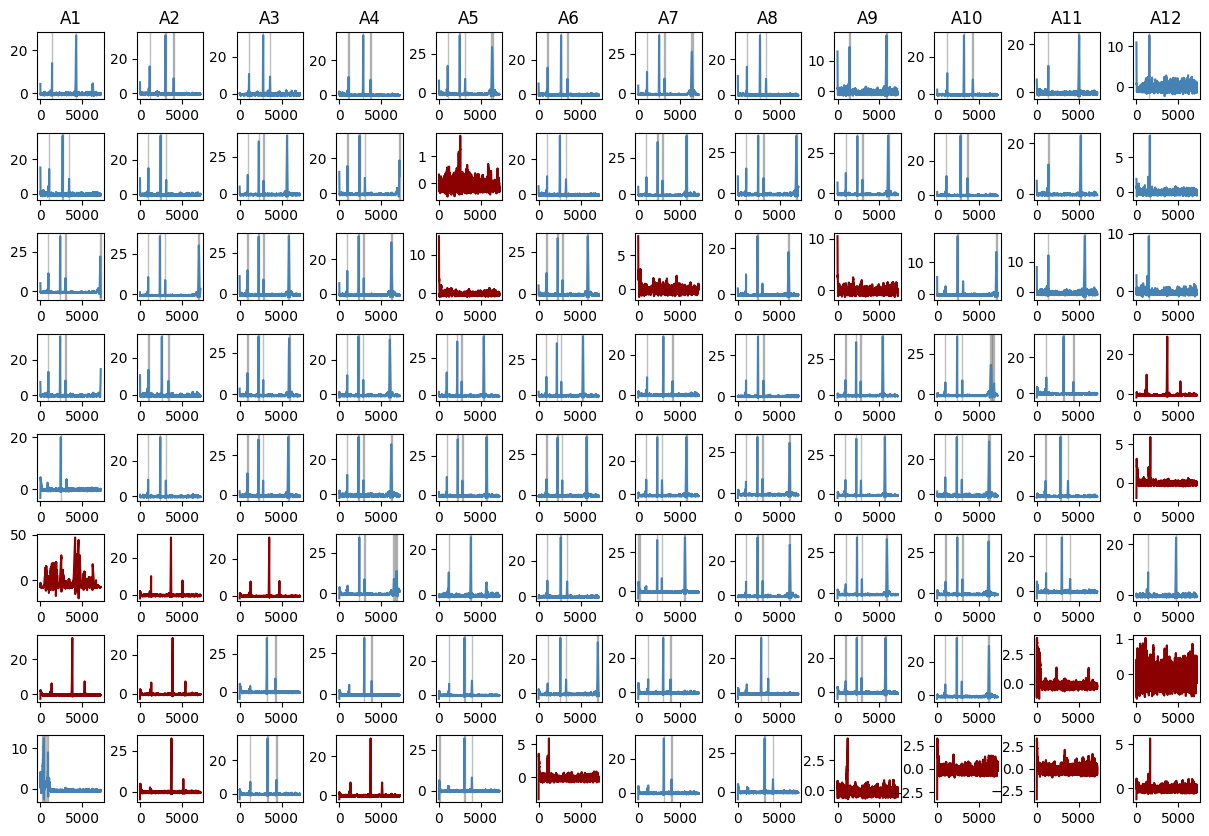

In [94]:
# plot_chromatography_data(processed_data1)
print(experiment_folder)
plot_baseline_corrected_chromatograms(processed_data1)

<h1 style="text-align: center; font-size: 60px;">Playground</h1>


In [75]:
def get_compound_peaks(data,compound):
    peaks = []
    for well,well_data in processed_data1.items():
        if(well_data["column_status"] == "good"):
            for peak in well_data["peaks"]:
                if (peak["compound"] == compound):
                    peaks.append(peak)

    return peaks

def plot_peak_rt_histogram(data,compound):
    peaks = get_compound_peaks(processed_data1, compound)
    retention_times = [peak["peak_position"] for peak in peaks]  # Using list comprehension
    
    # Plotting the histogram
    plt.hist(retention_times, bins=20)  # You can adjust the number of bins as needed
    plt.title(f'Peak Retention Times for Compound: {compound}')
    plt.xlabel('Retention Time')
    plt.ylabel('Frequency')
    plt.show()
    

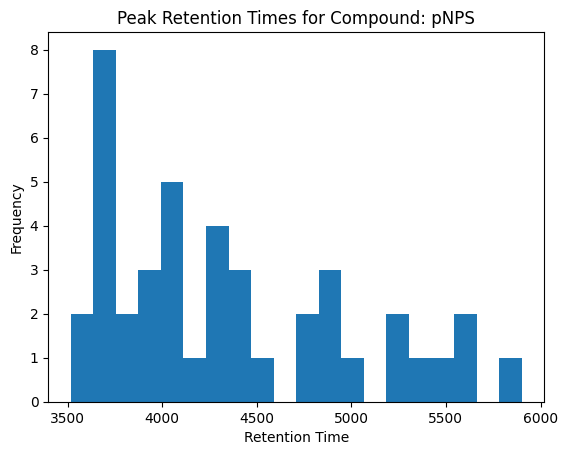

In [76]:
plot_peak_rt_histogram(processed_data1,"pNPS")

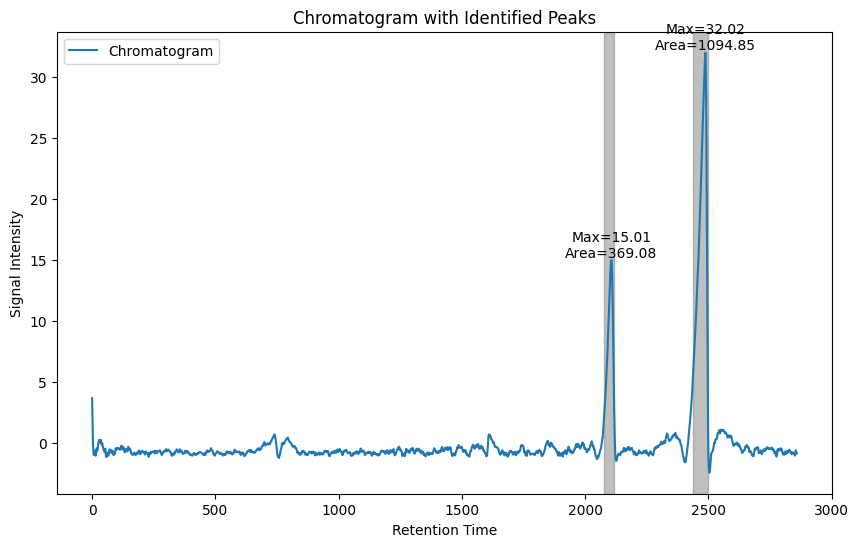

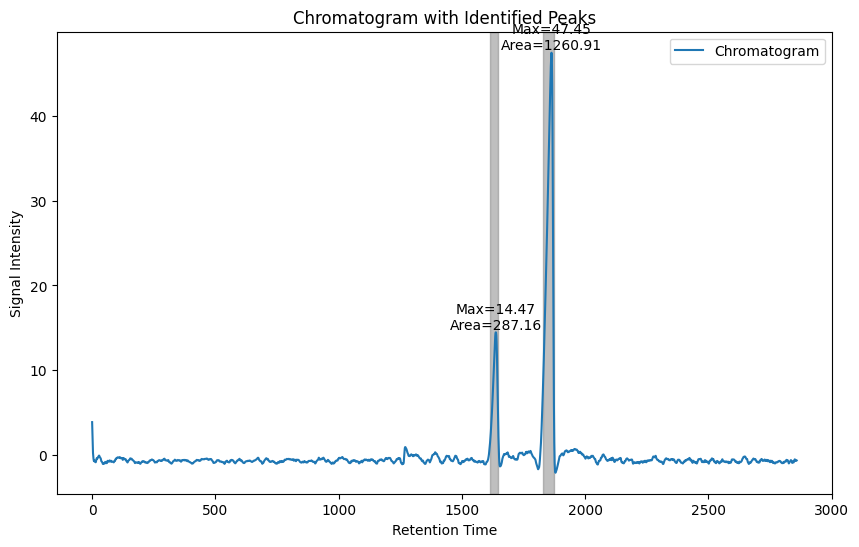

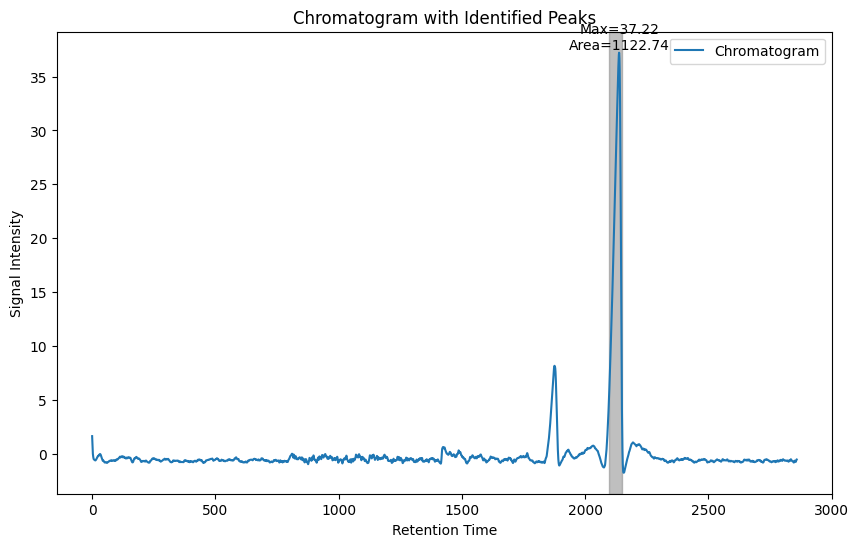

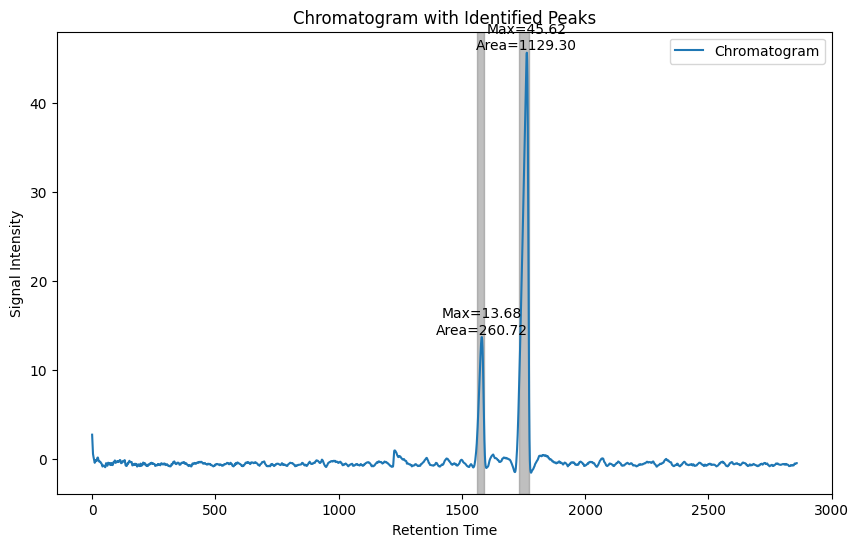

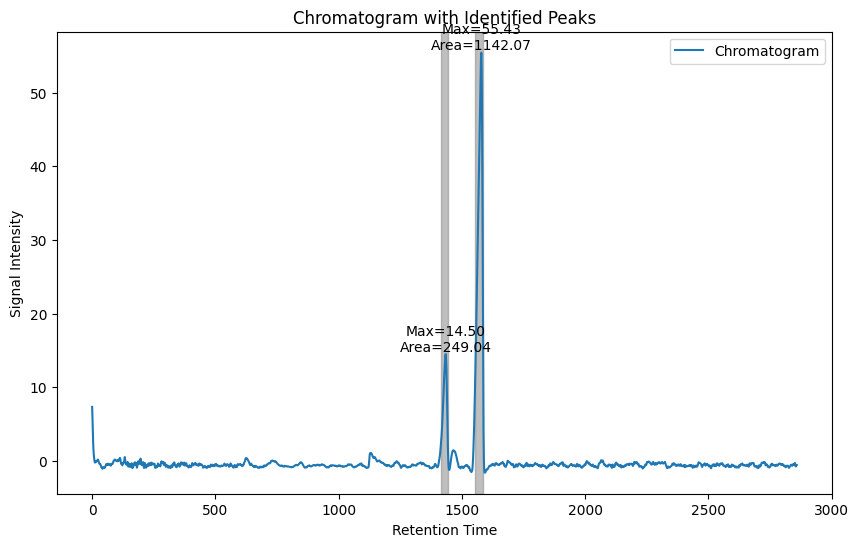

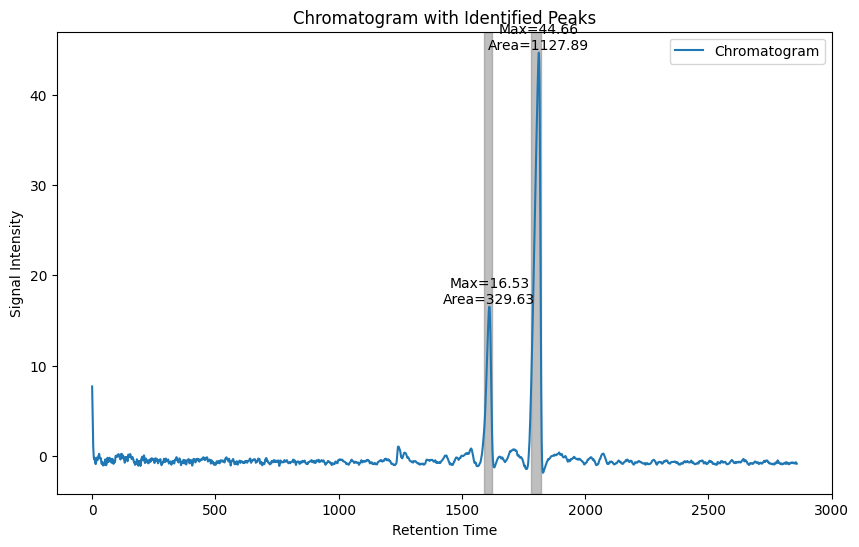

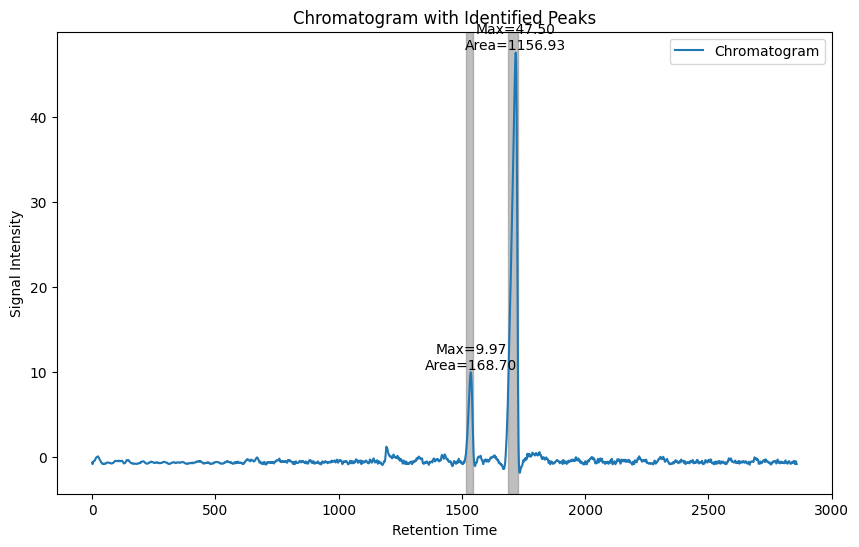

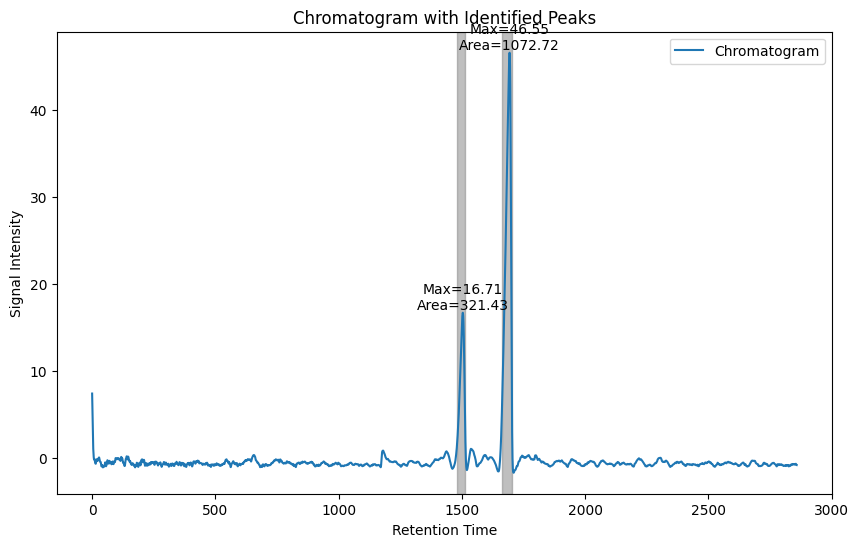

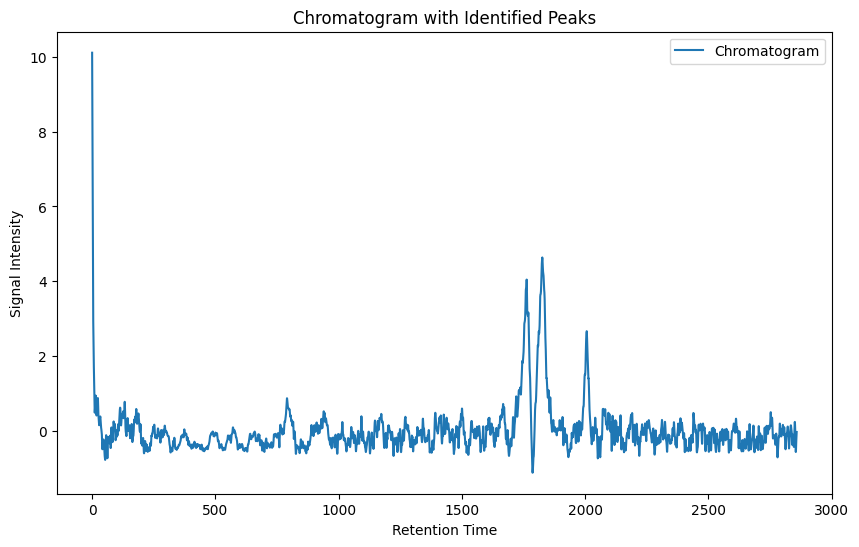

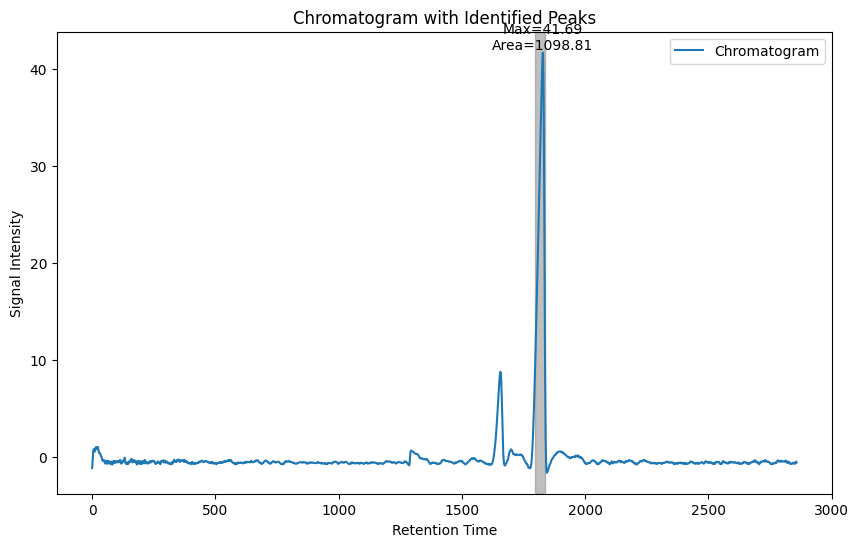

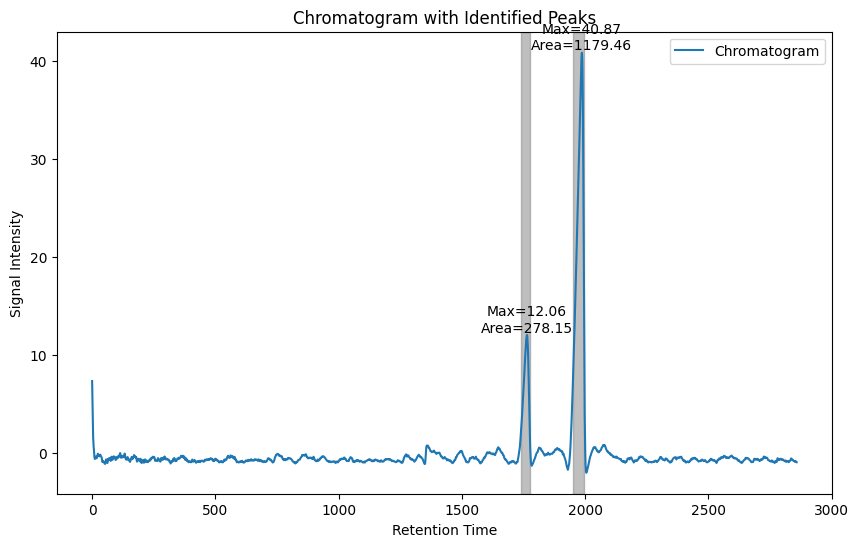

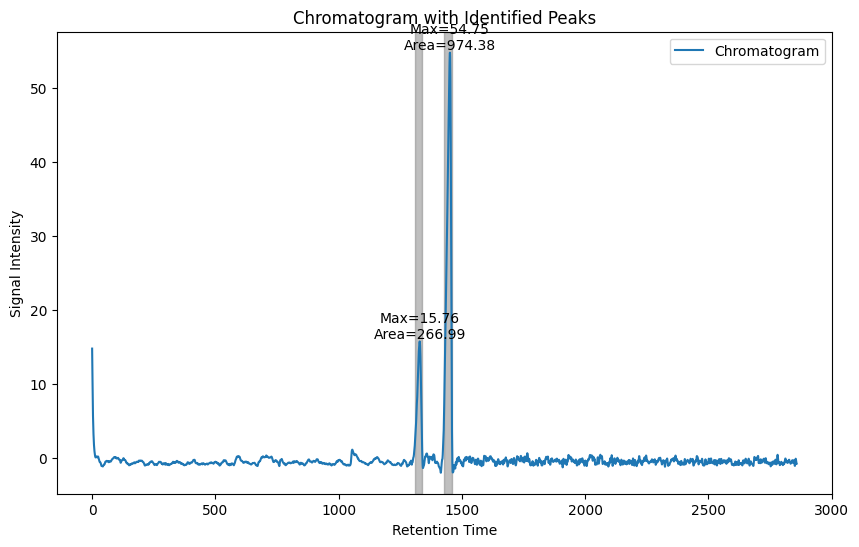

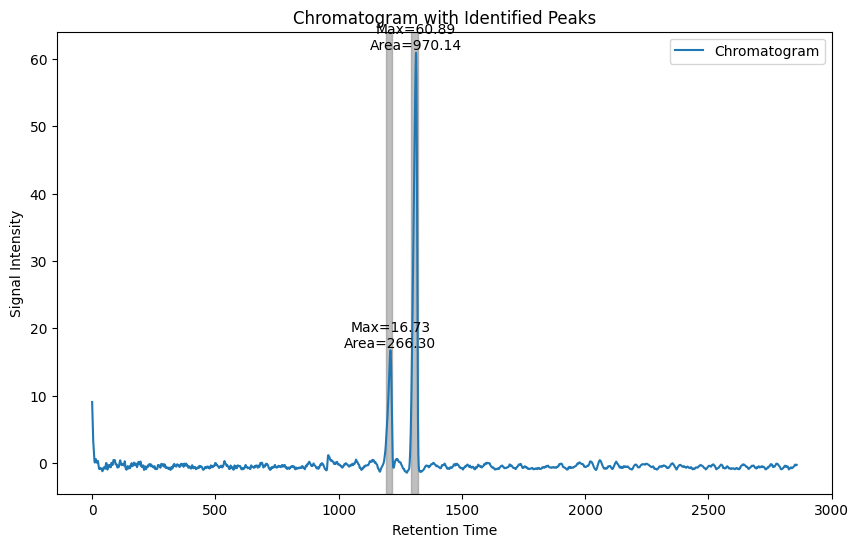

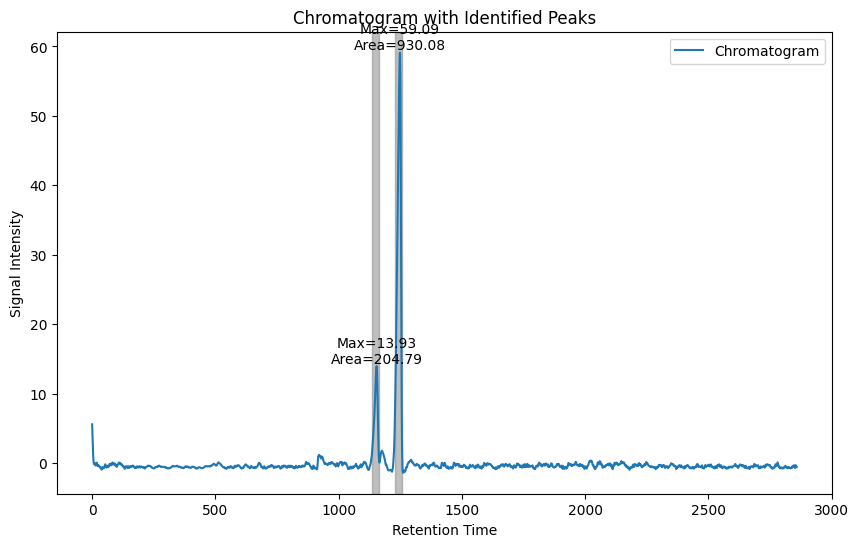

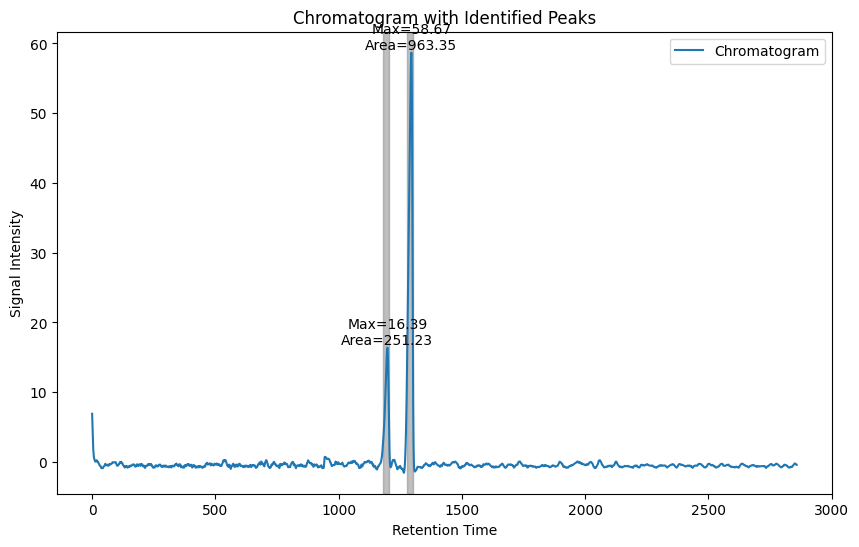

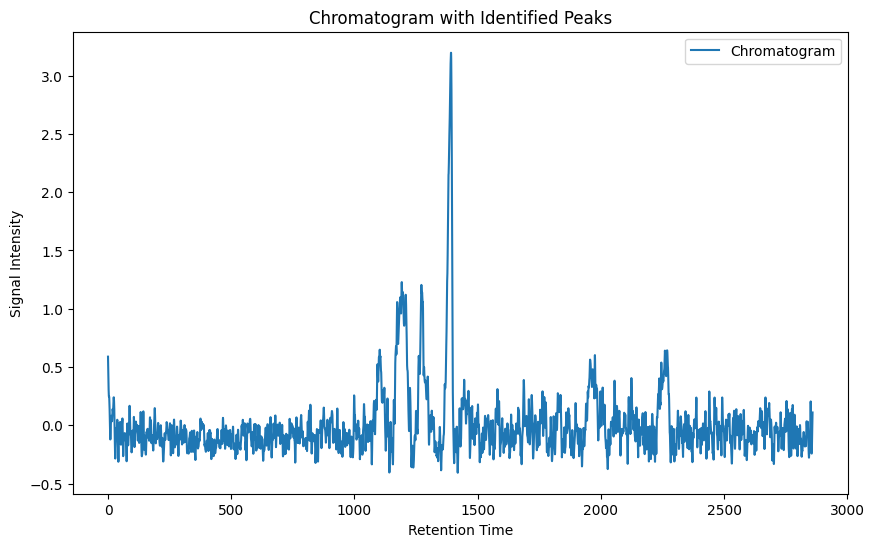

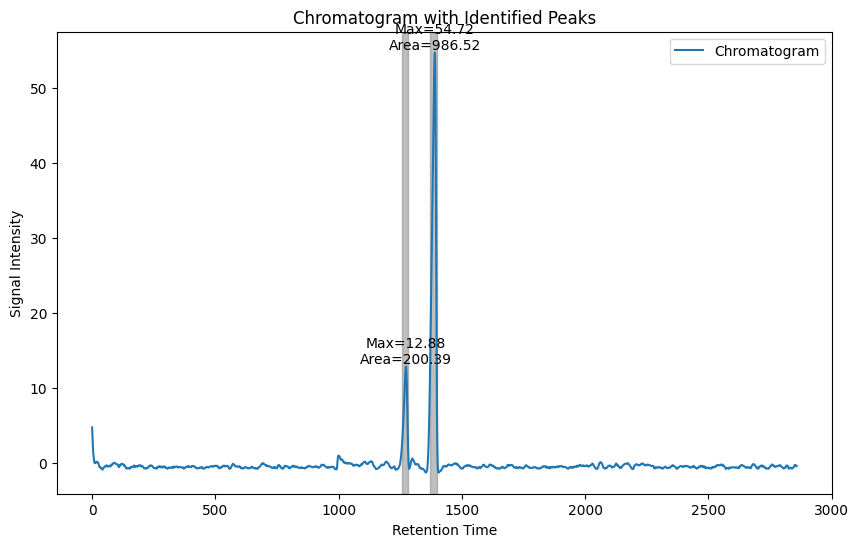

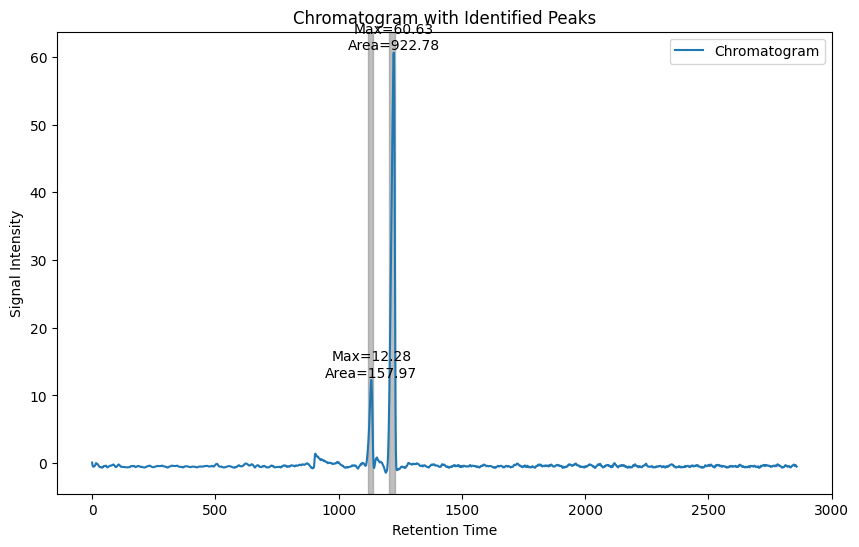

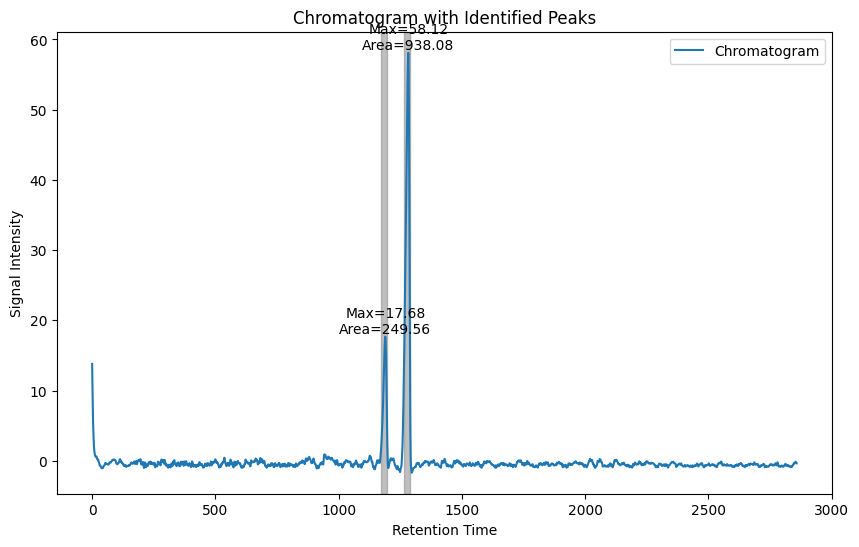

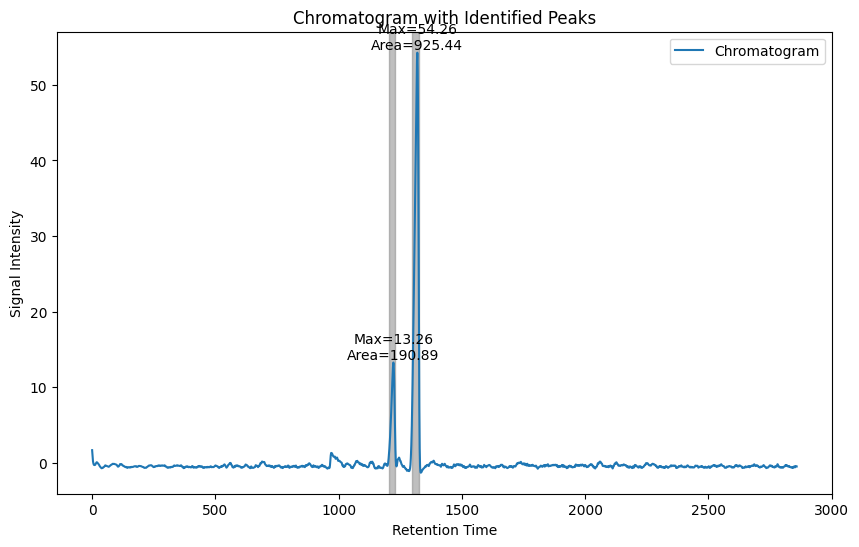

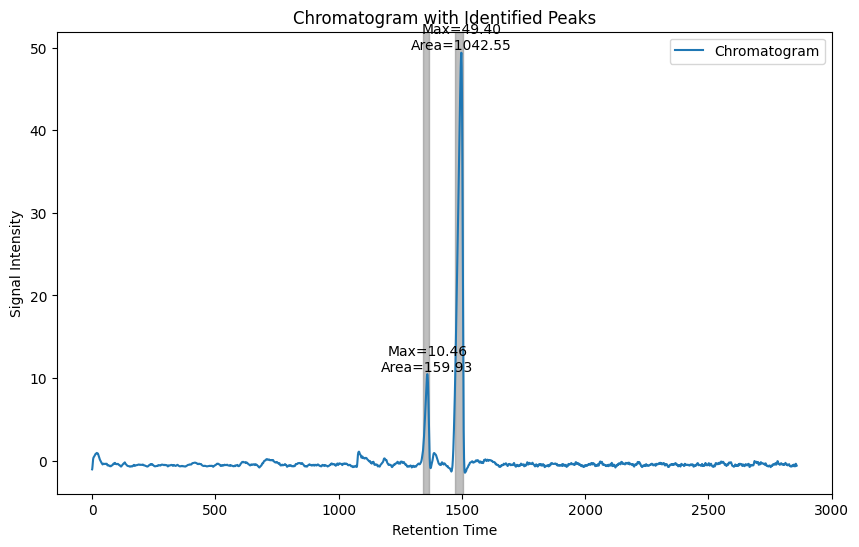

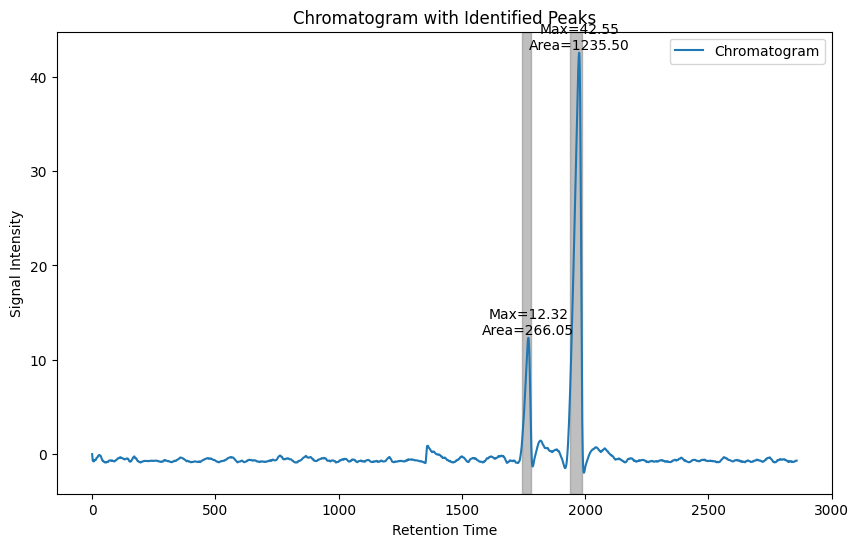

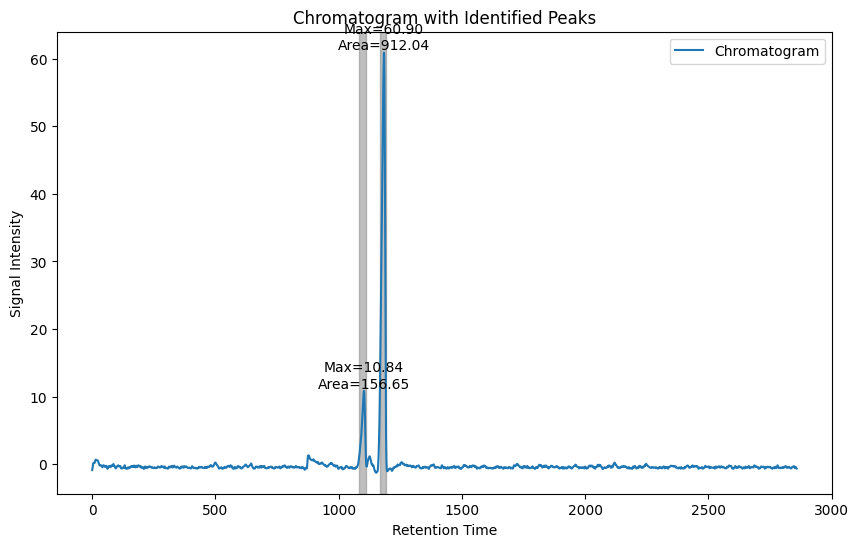

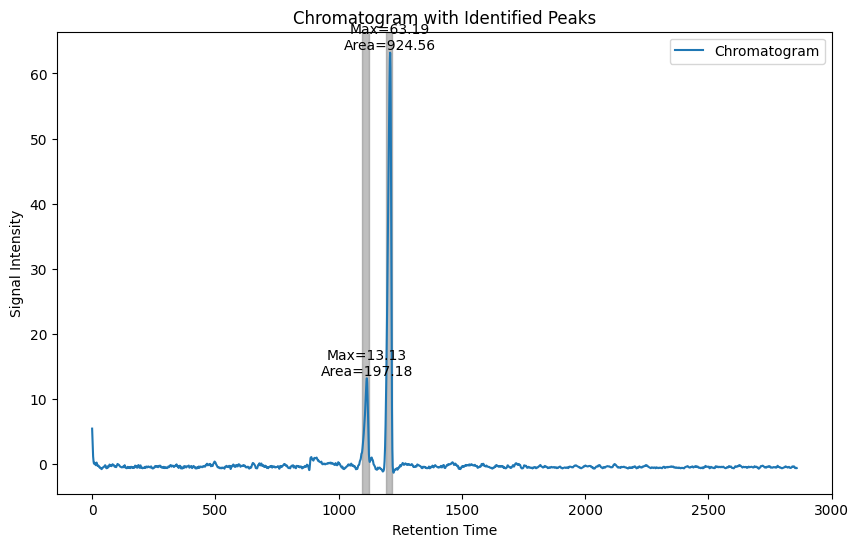

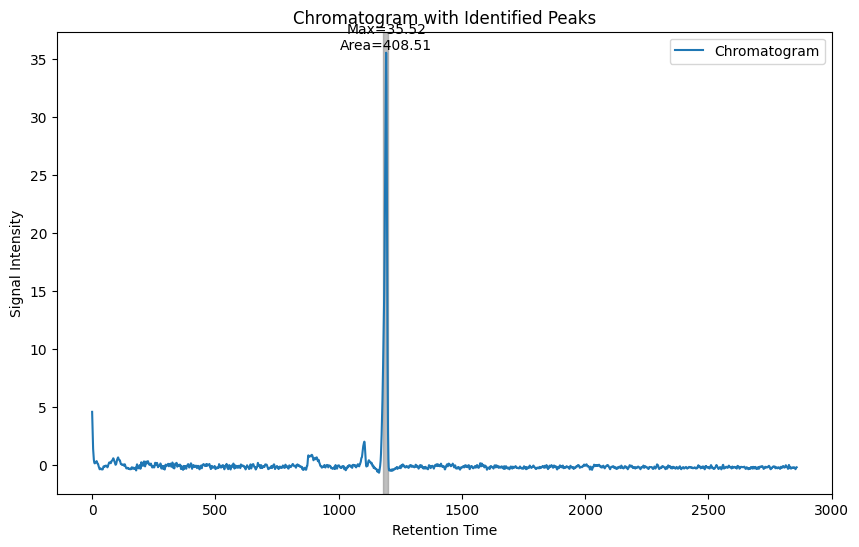

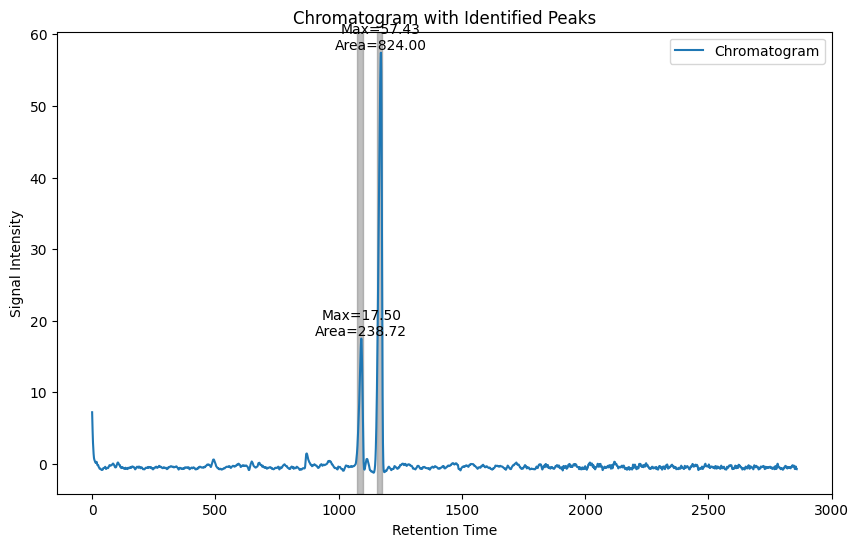

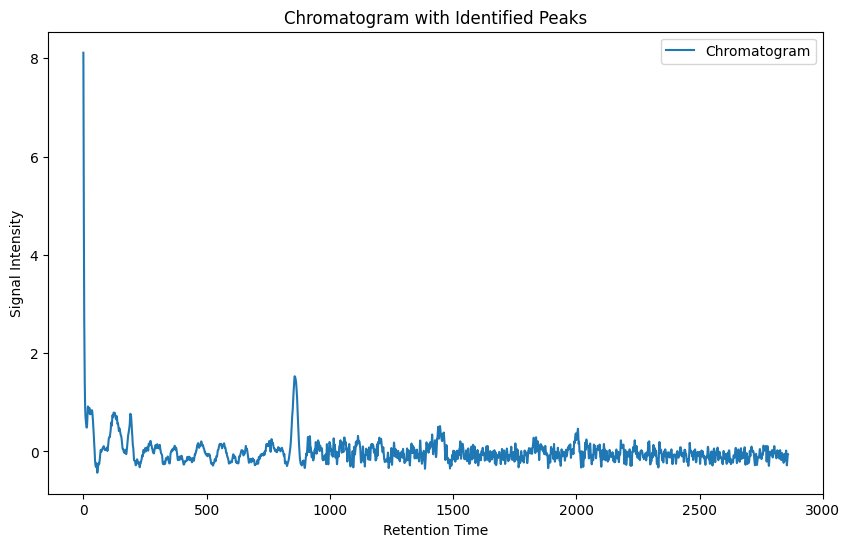

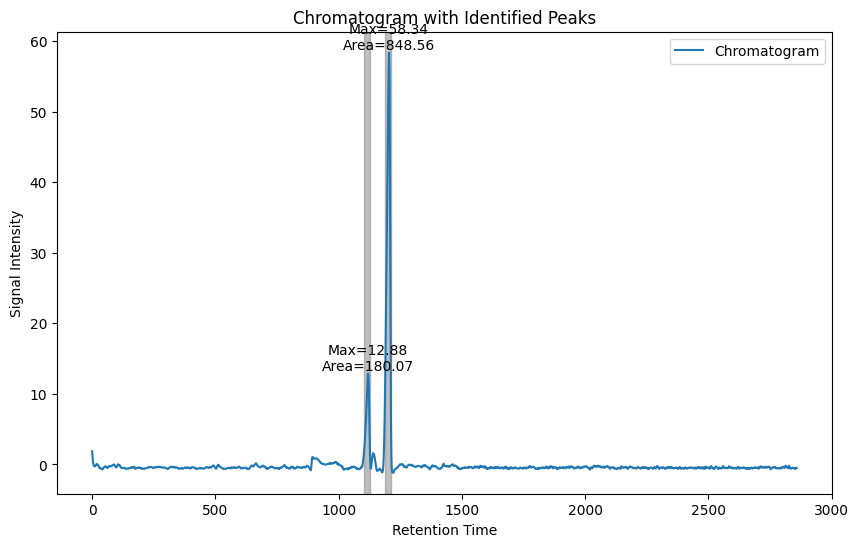

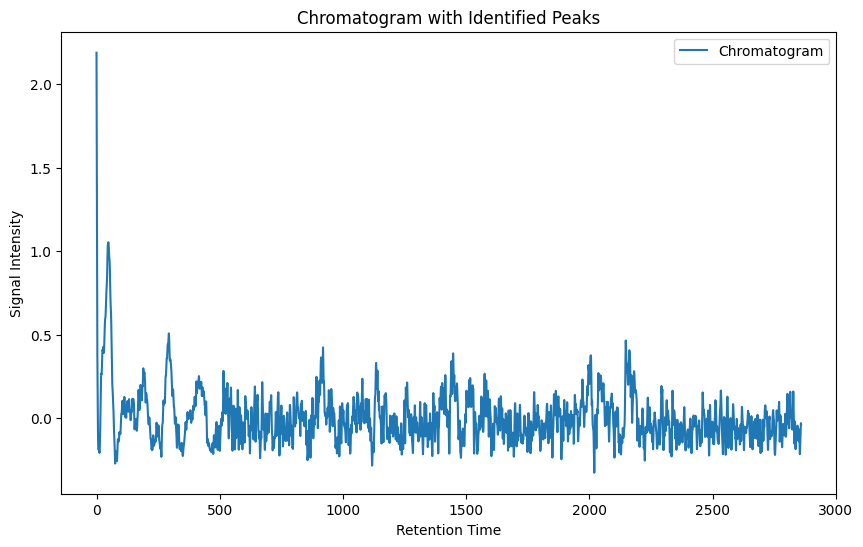

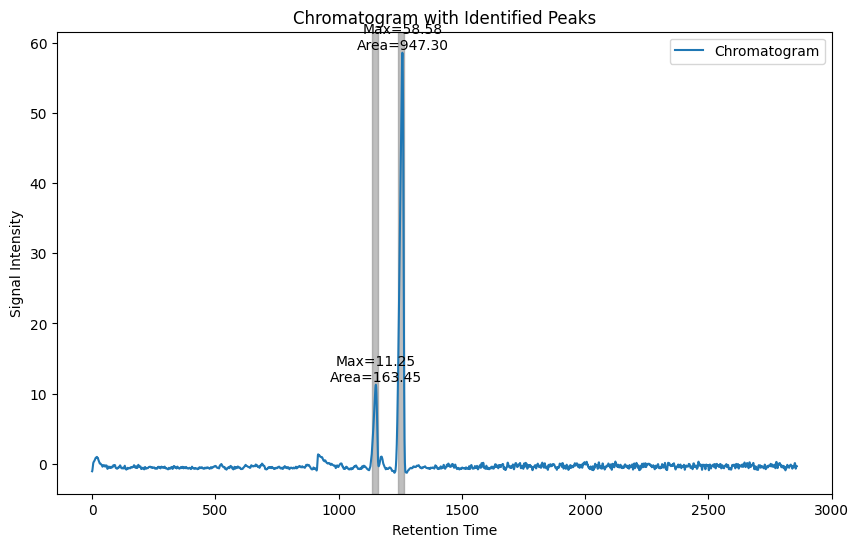

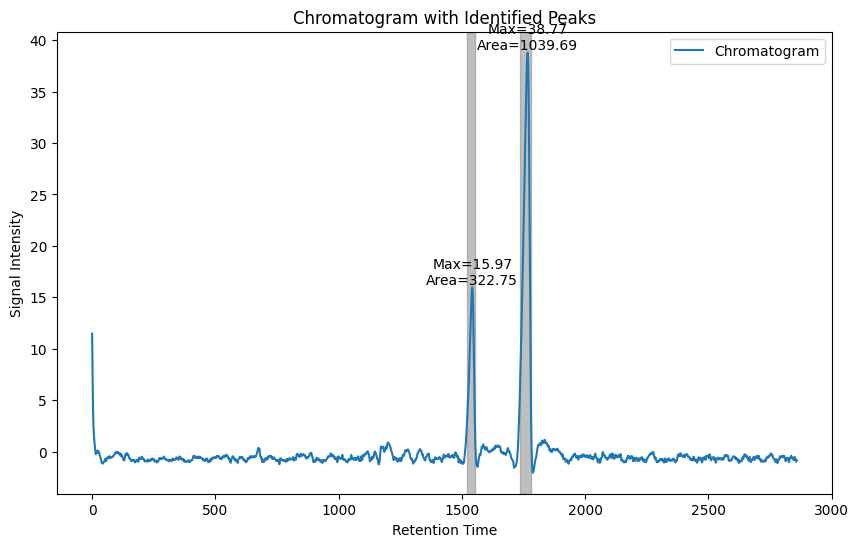

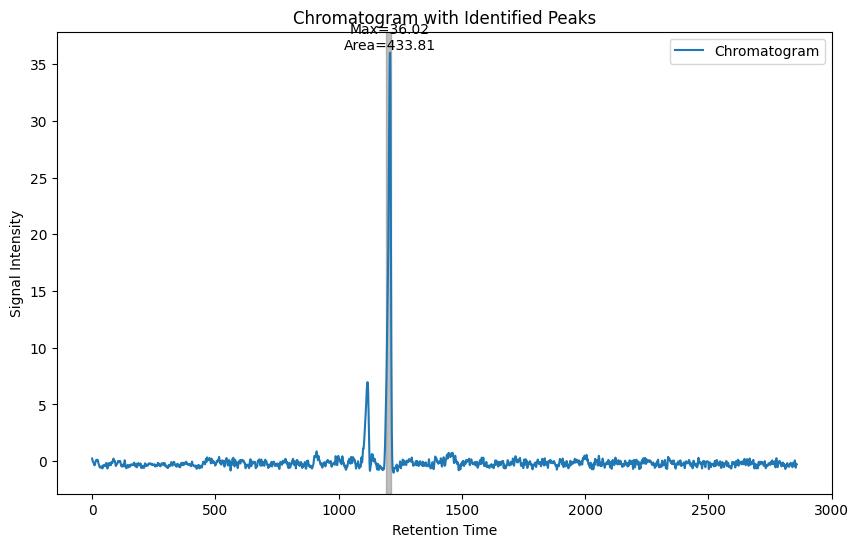

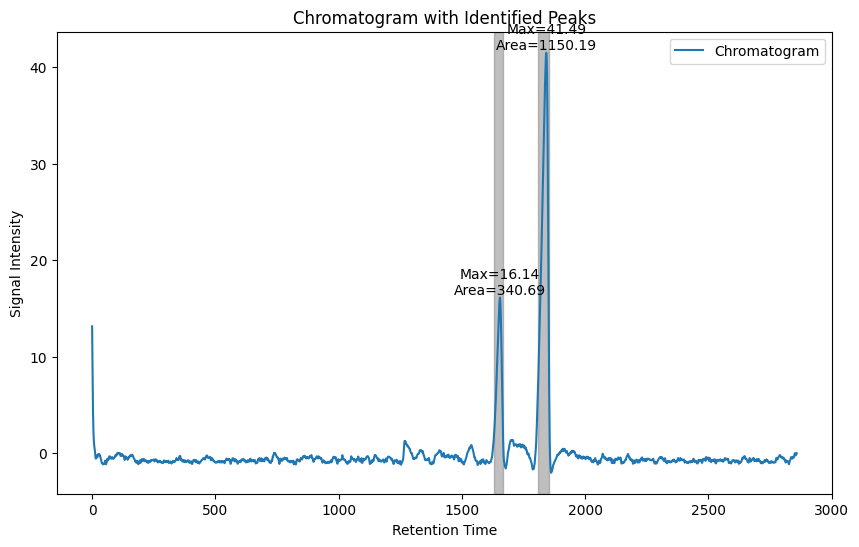

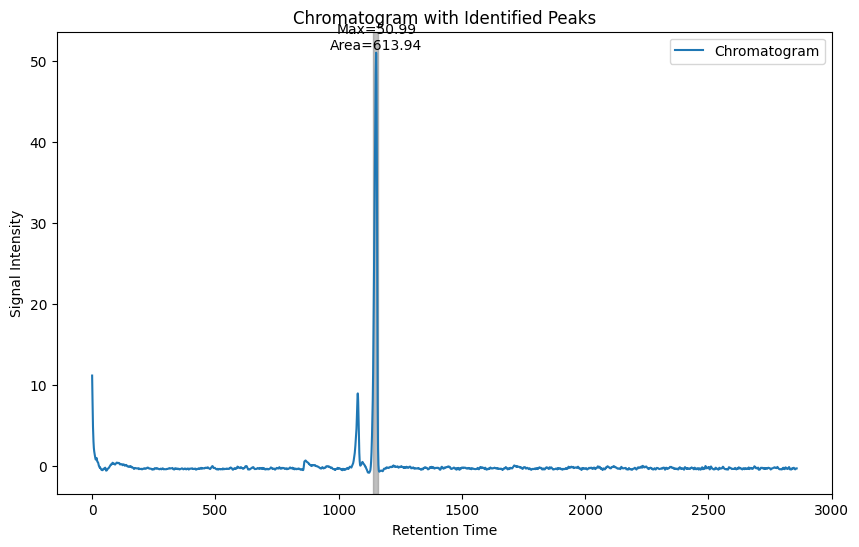

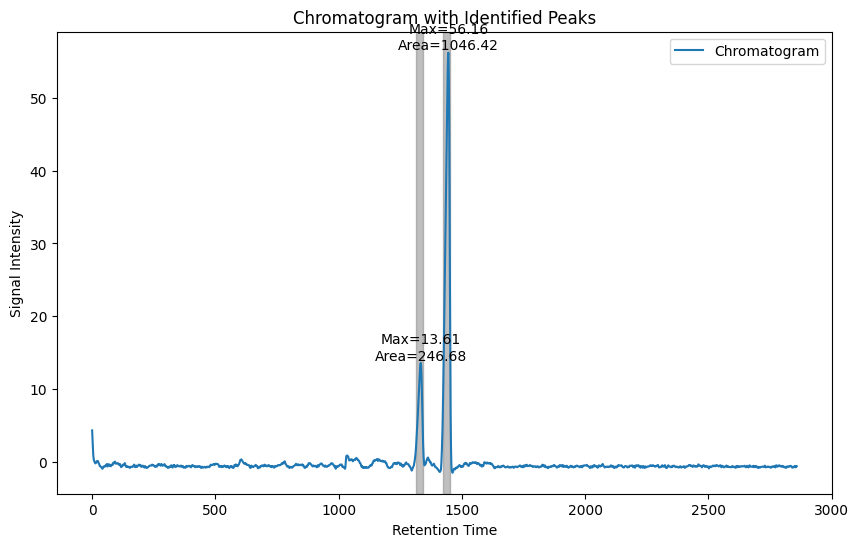

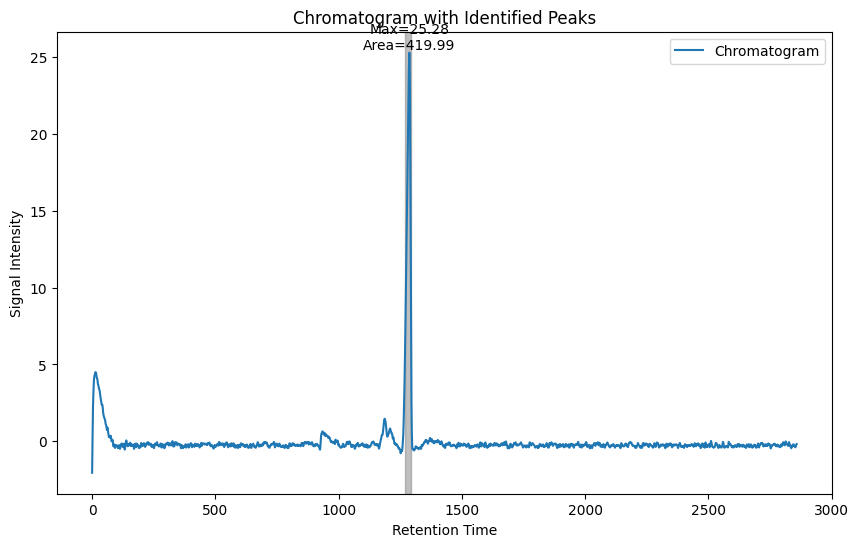

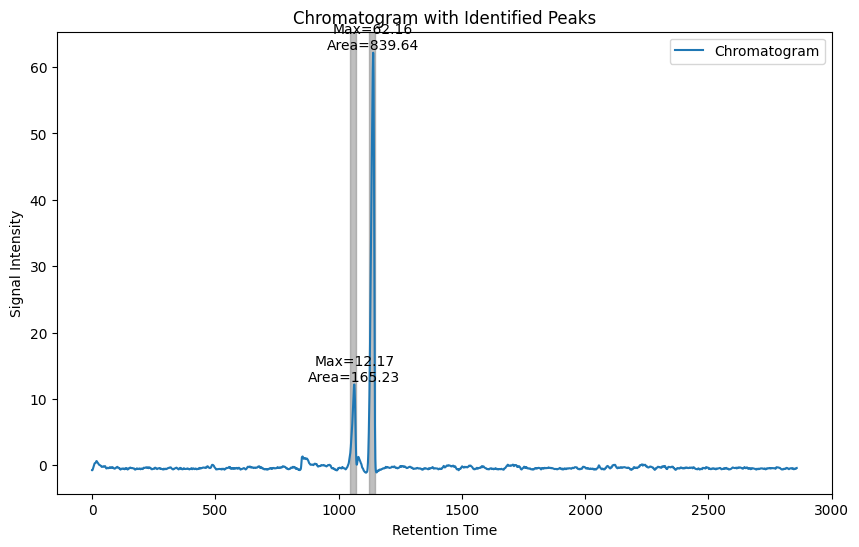

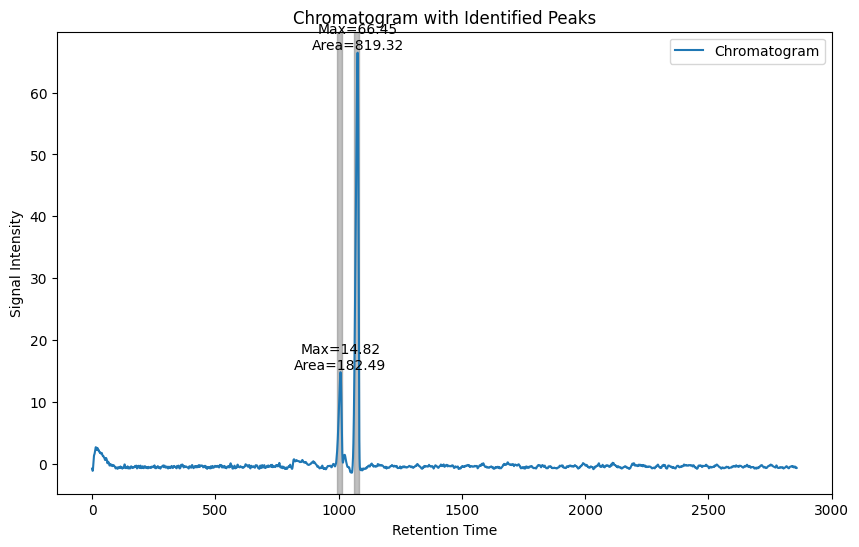

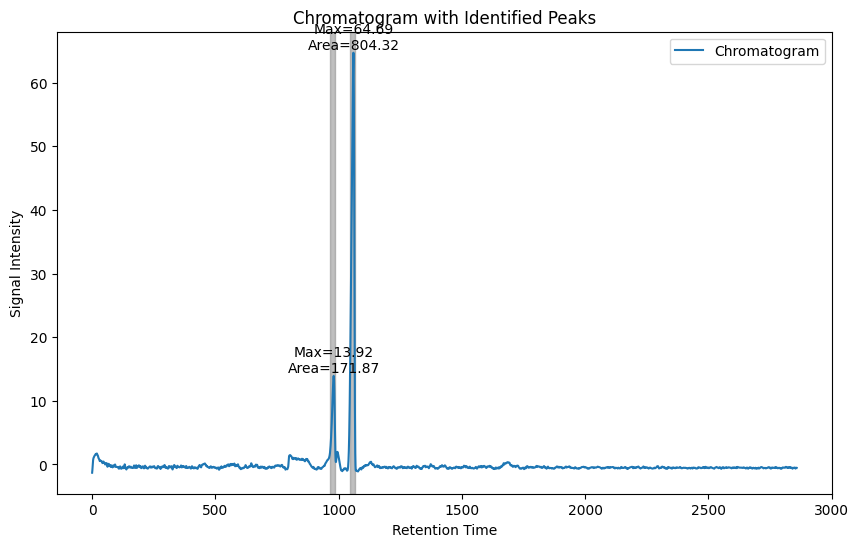

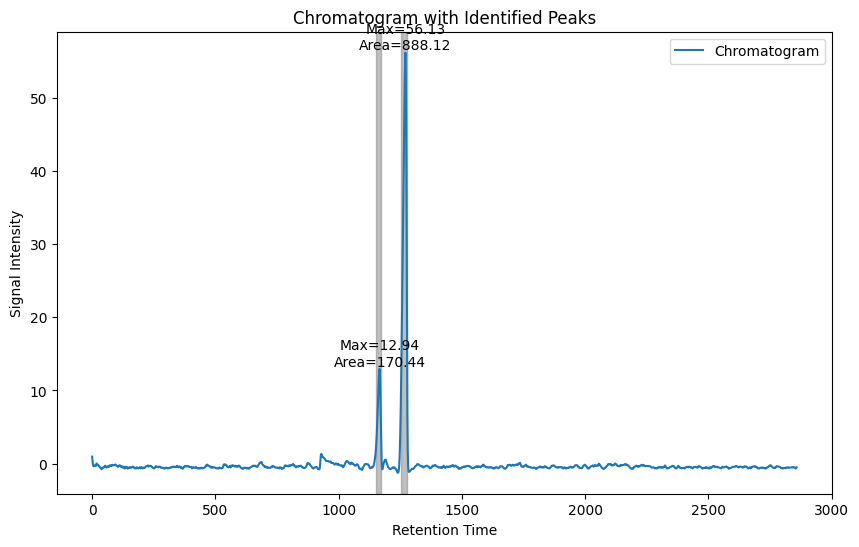

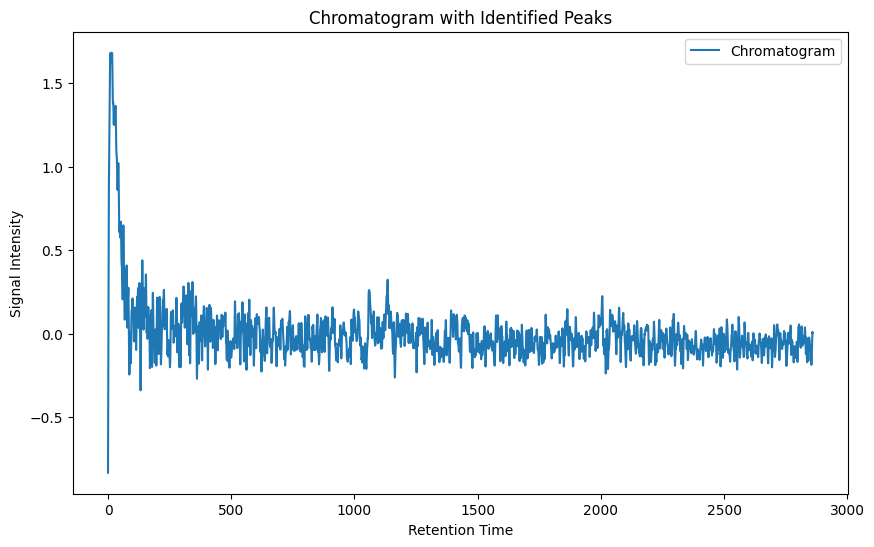

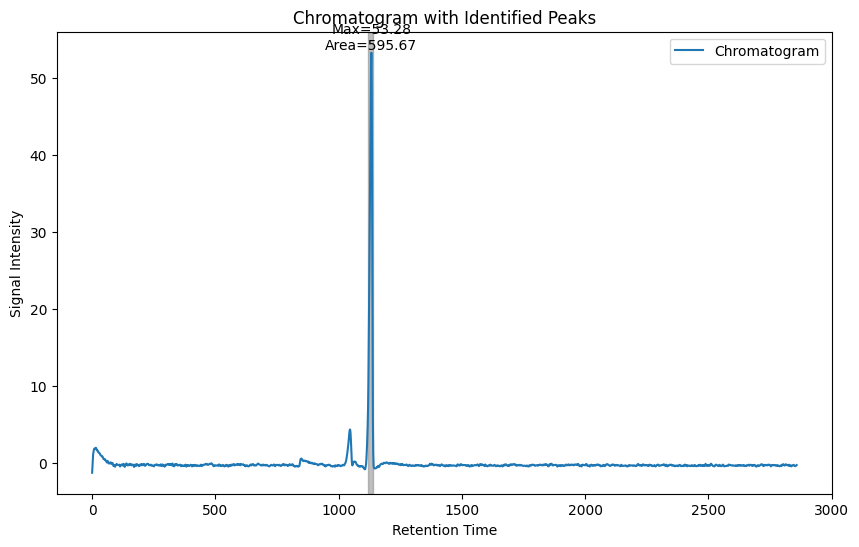

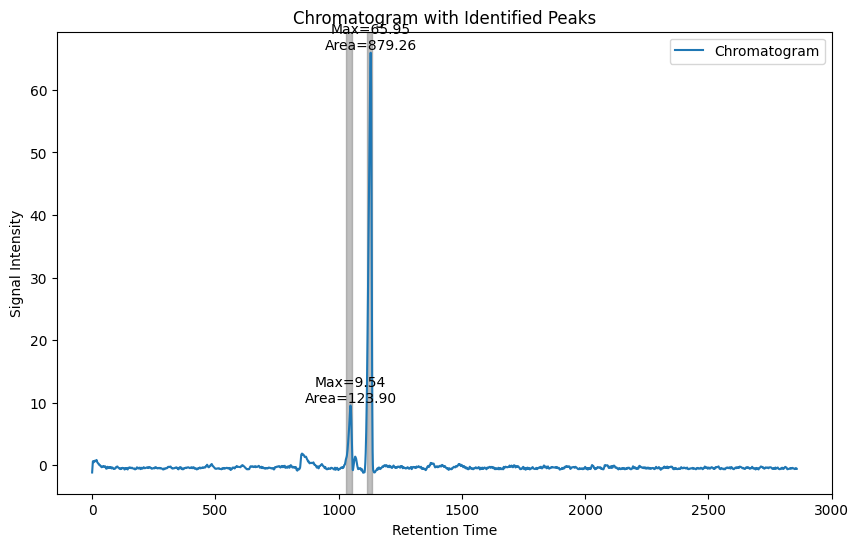

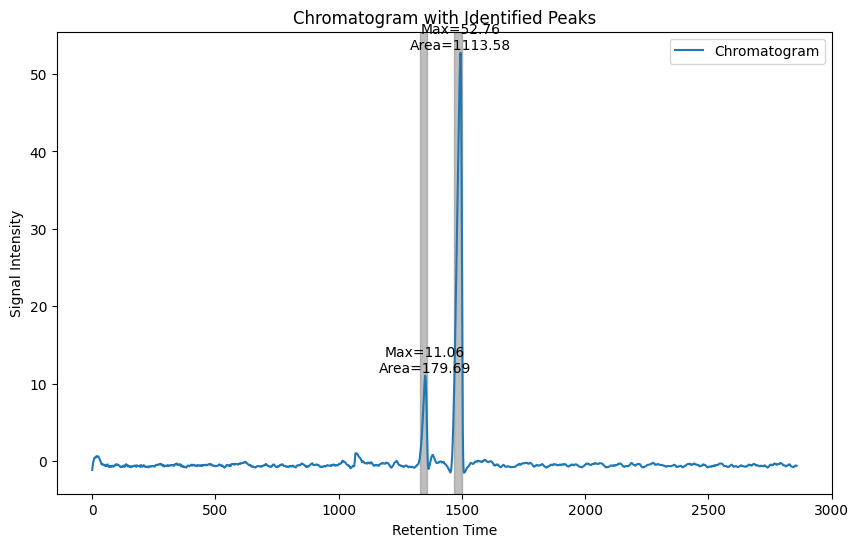

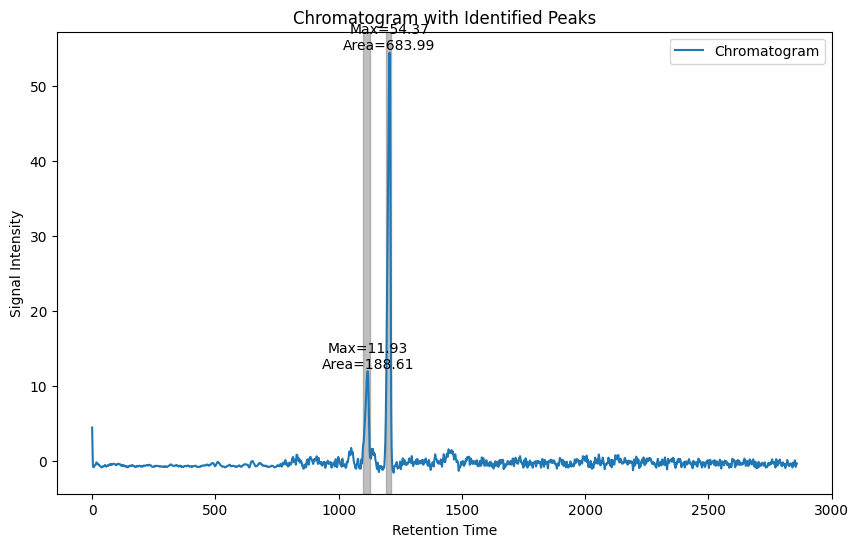

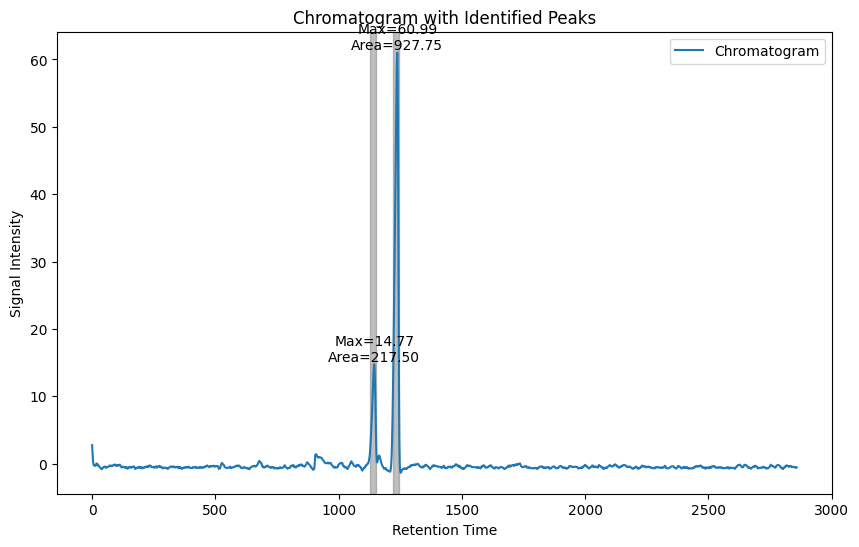

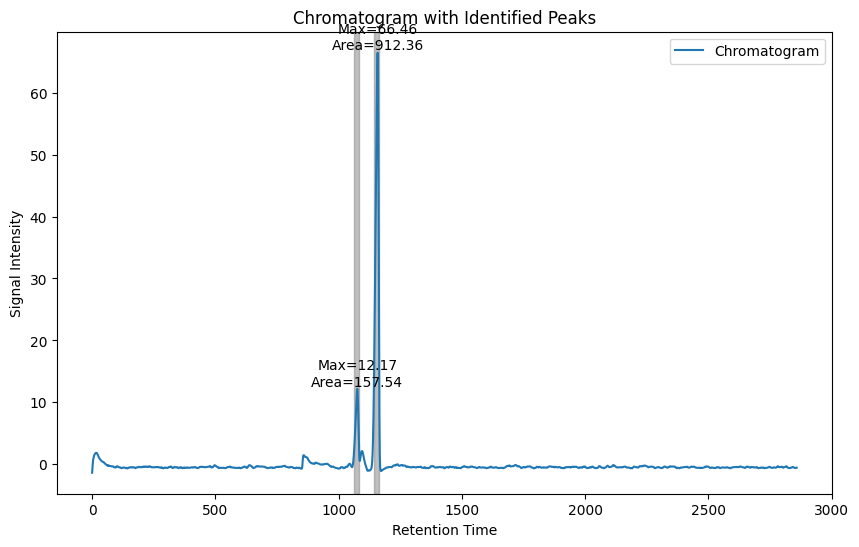

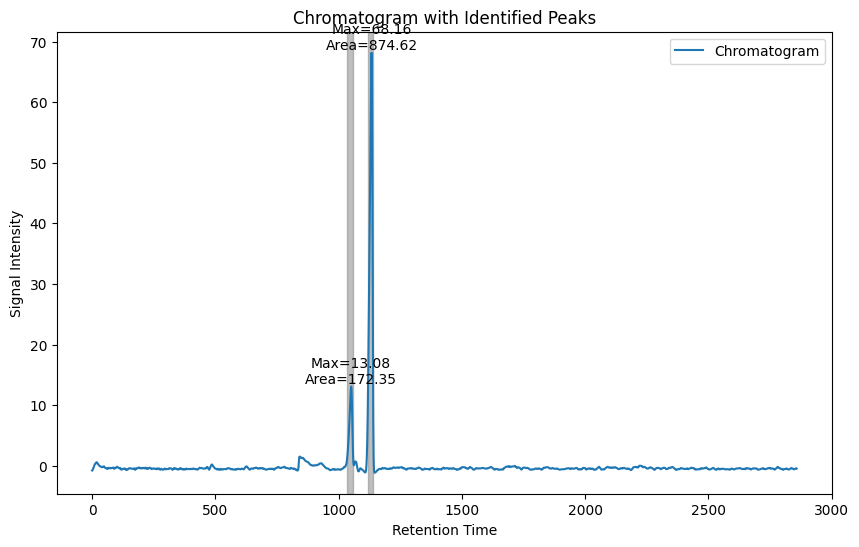

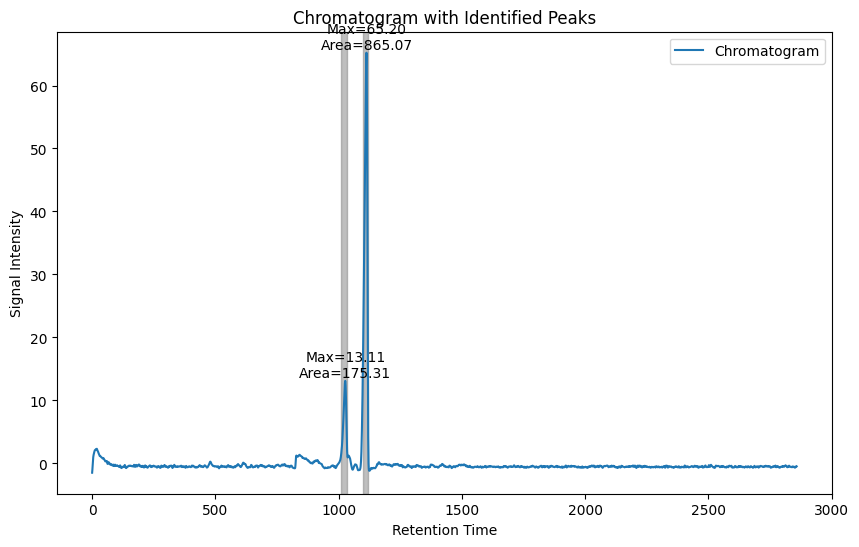

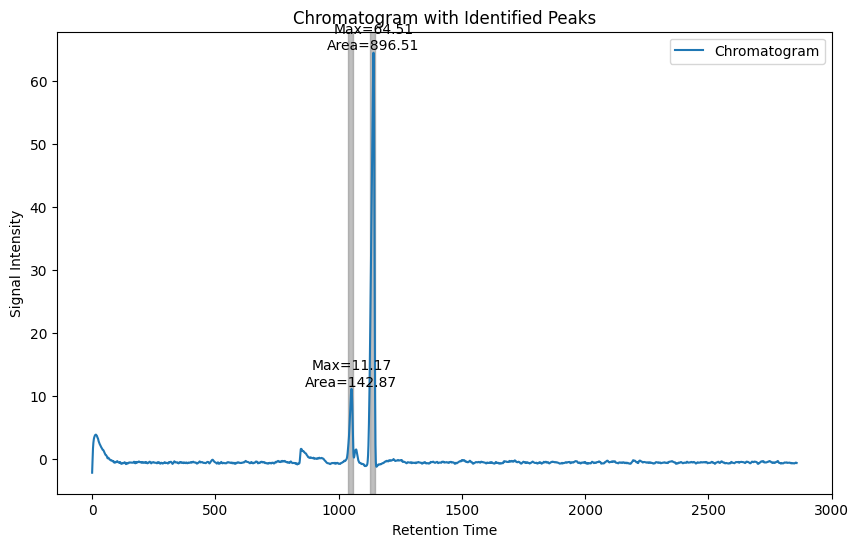

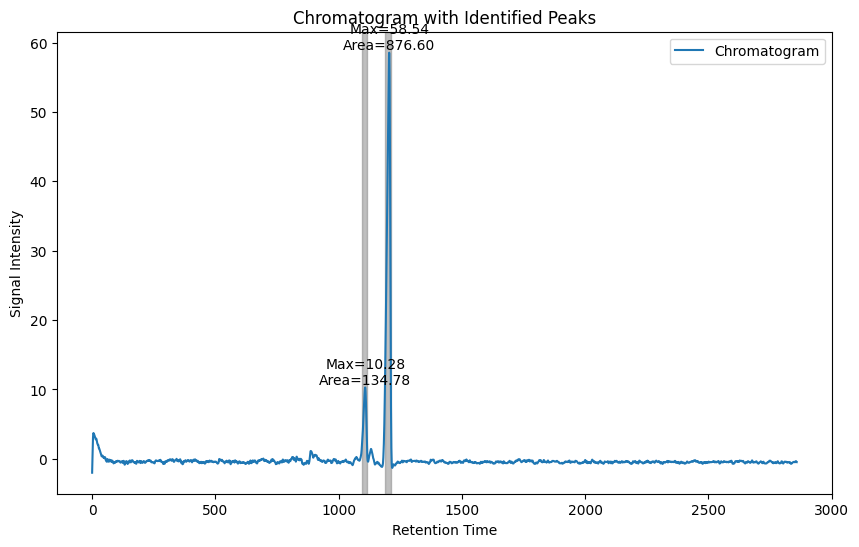

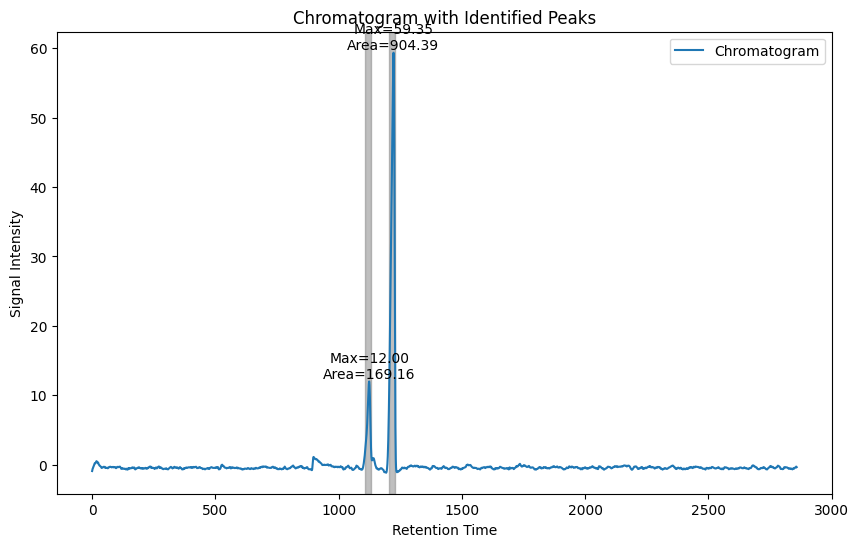

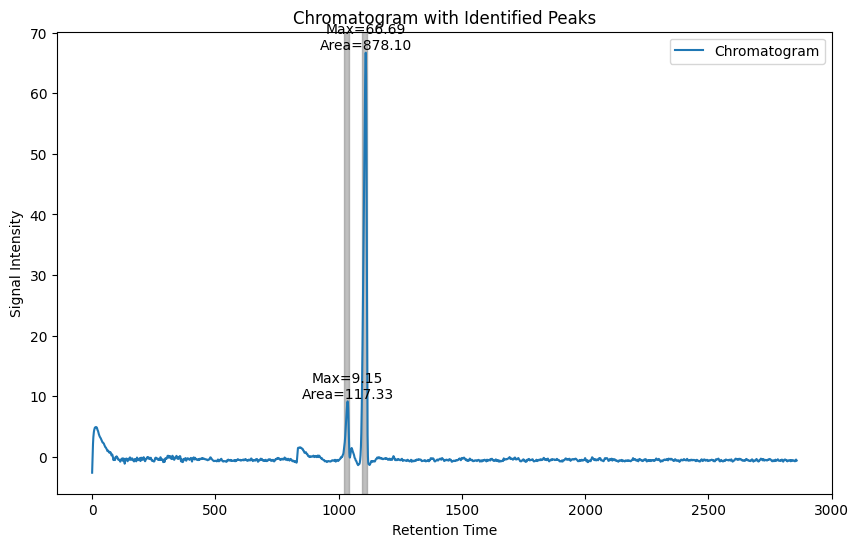

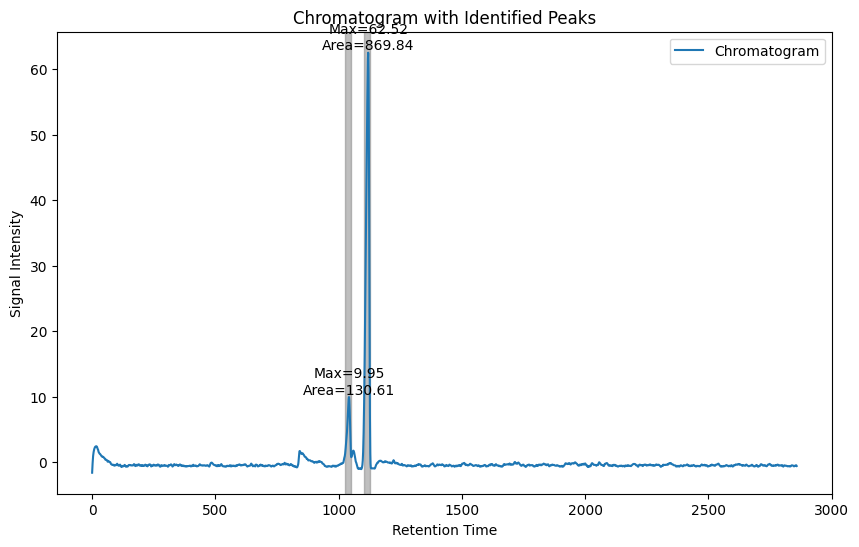

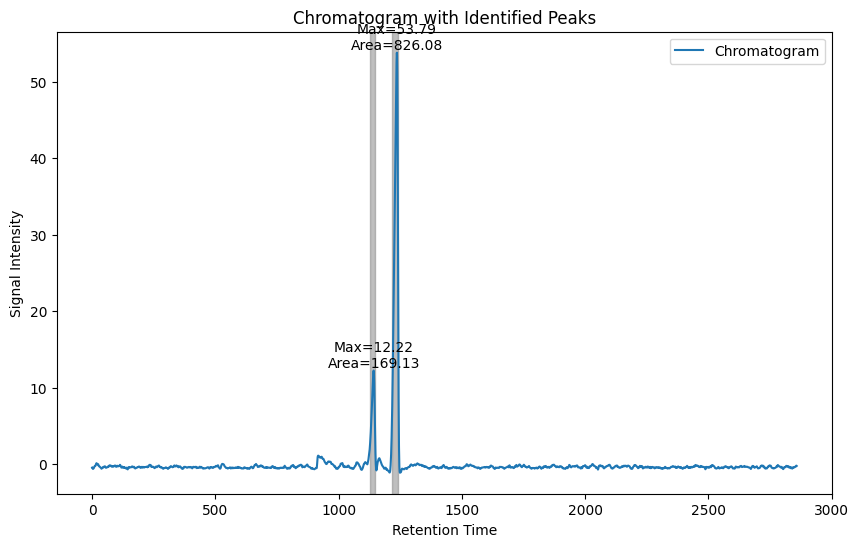

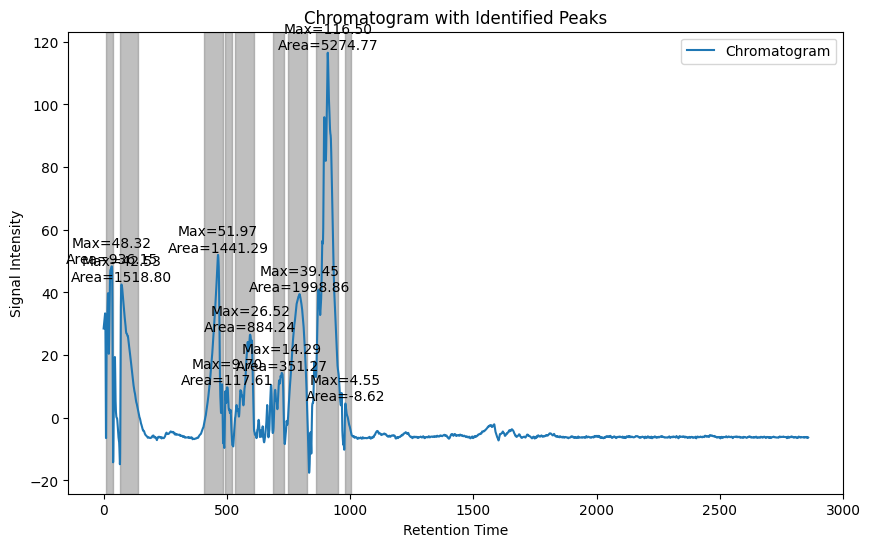

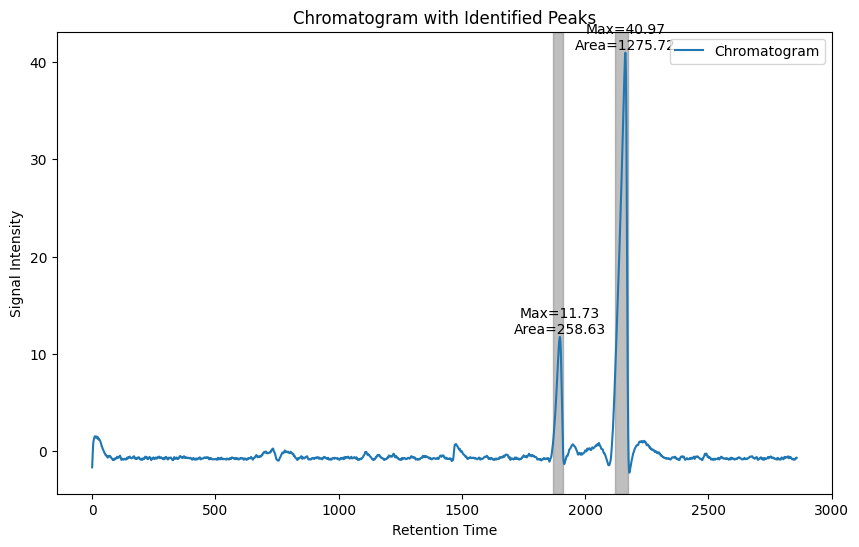

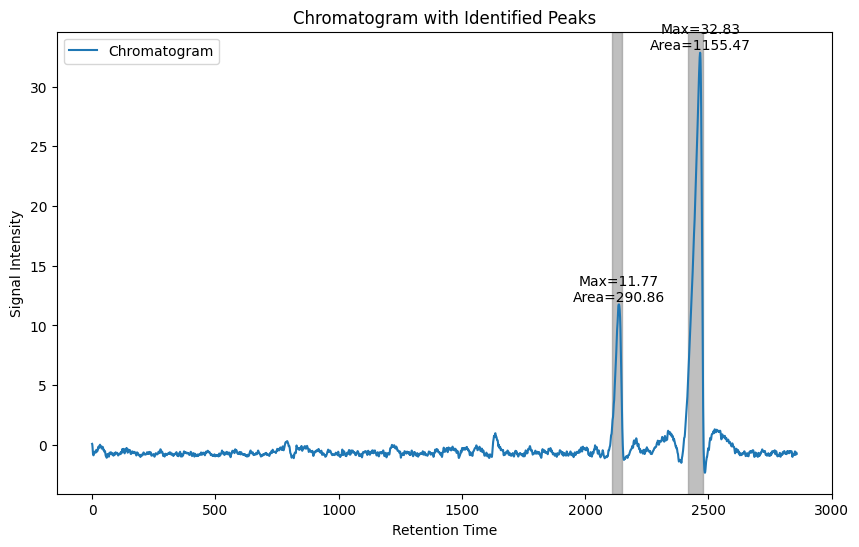

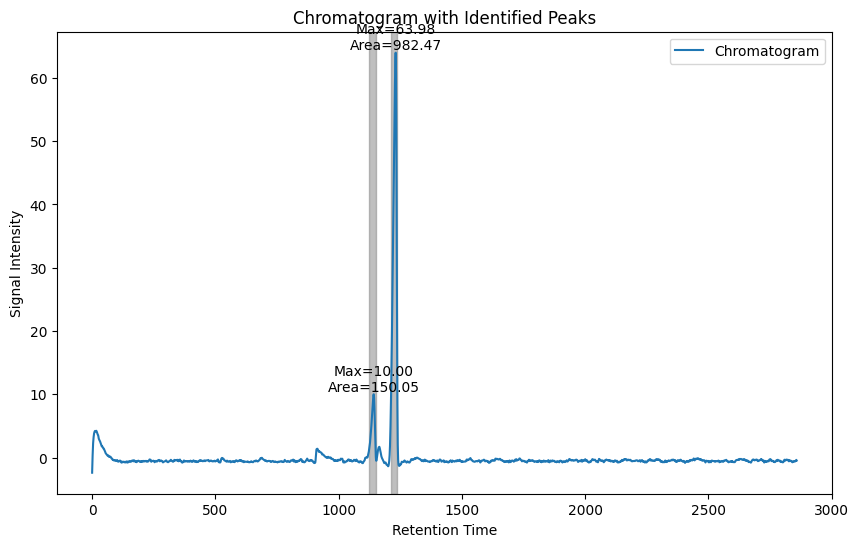

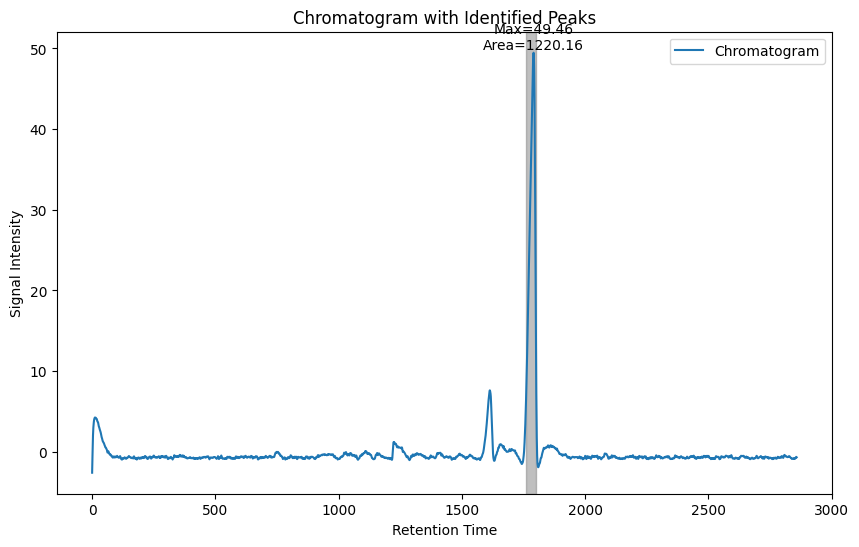

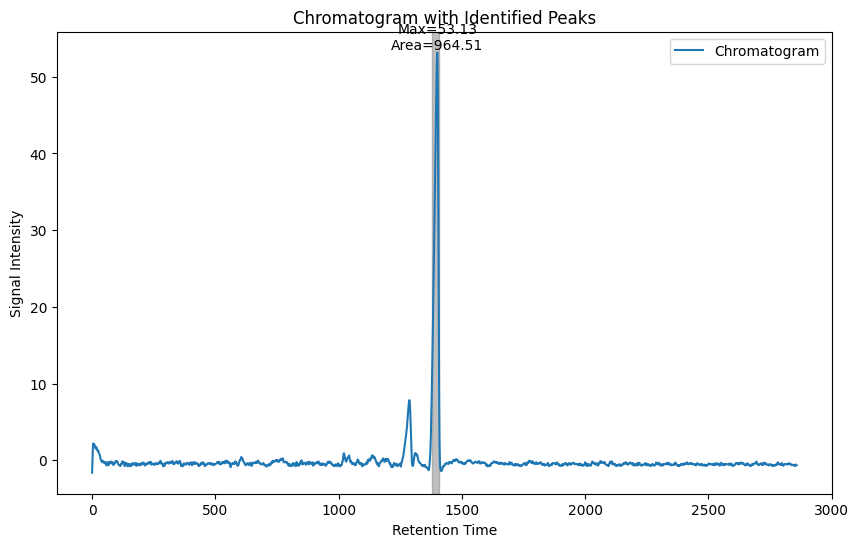

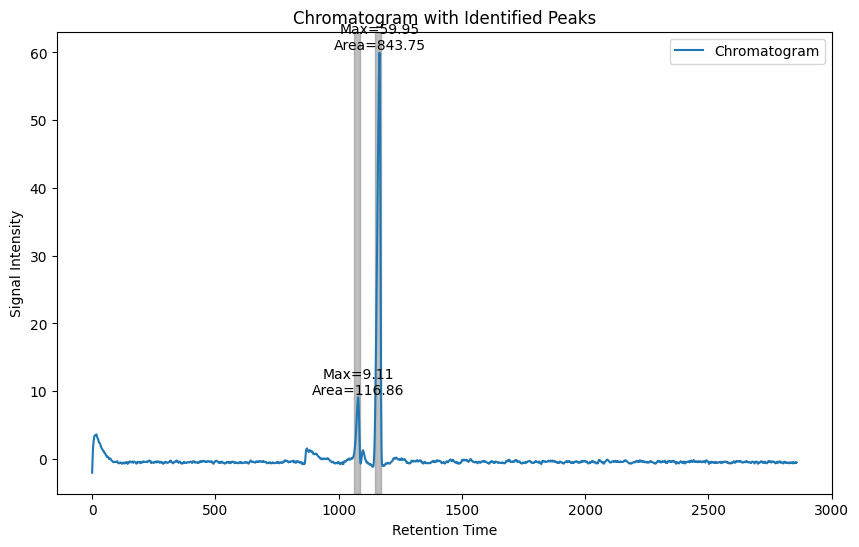

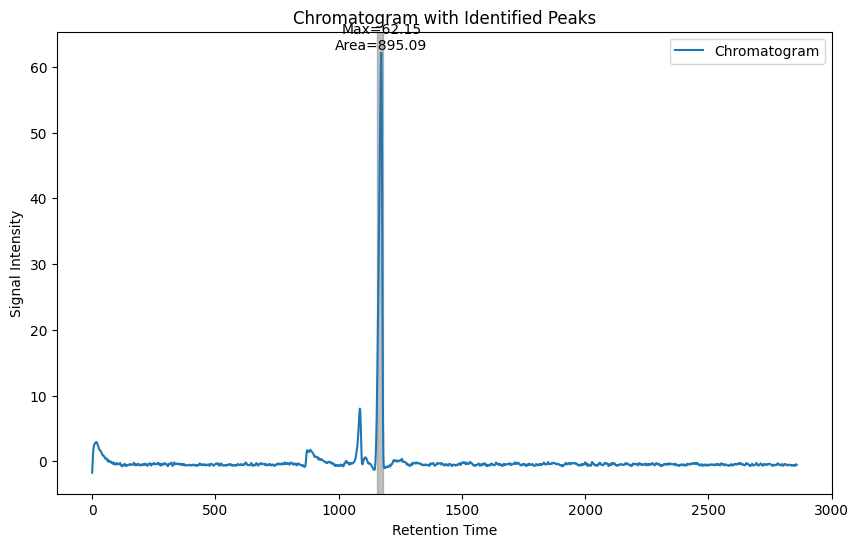

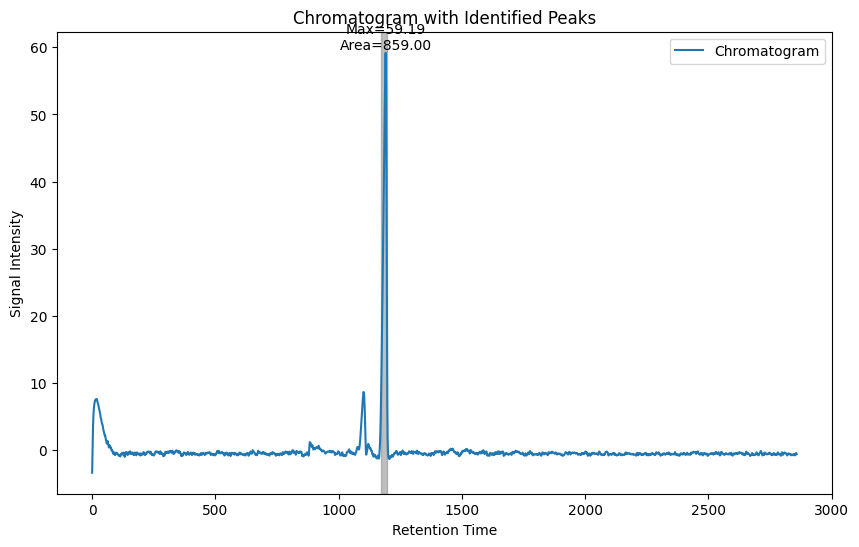

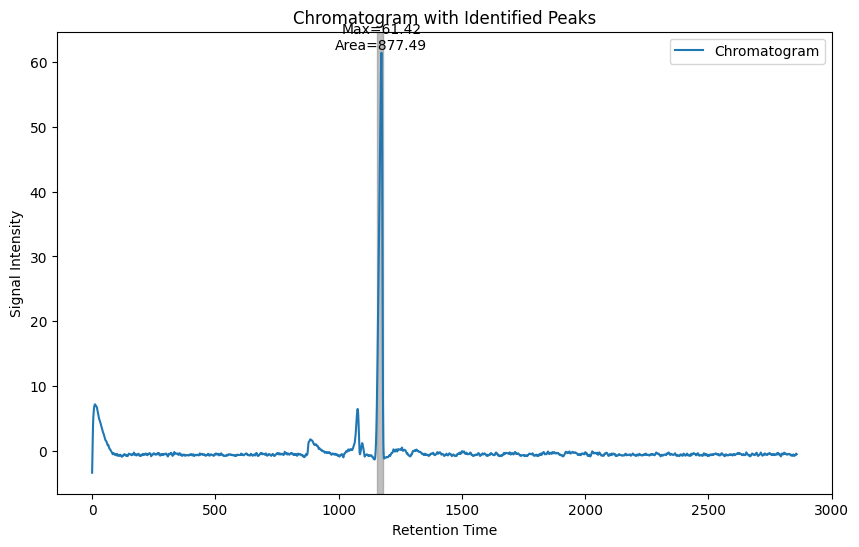

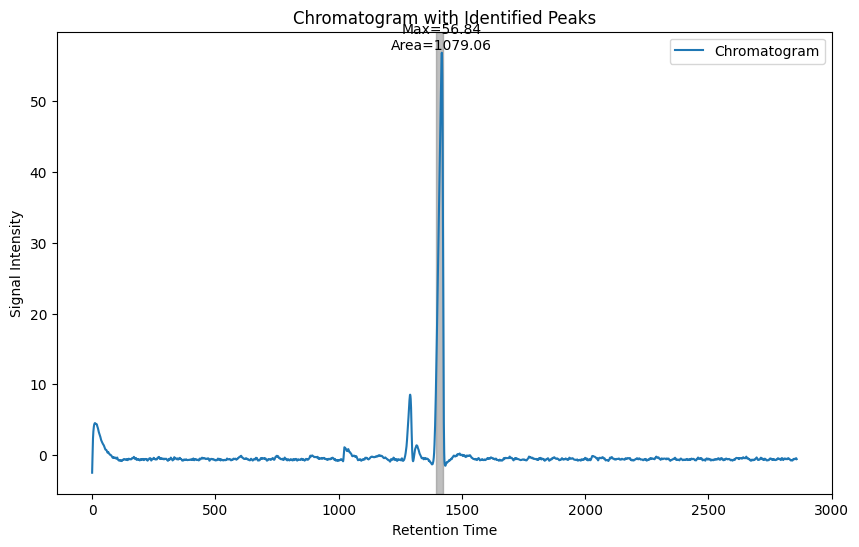

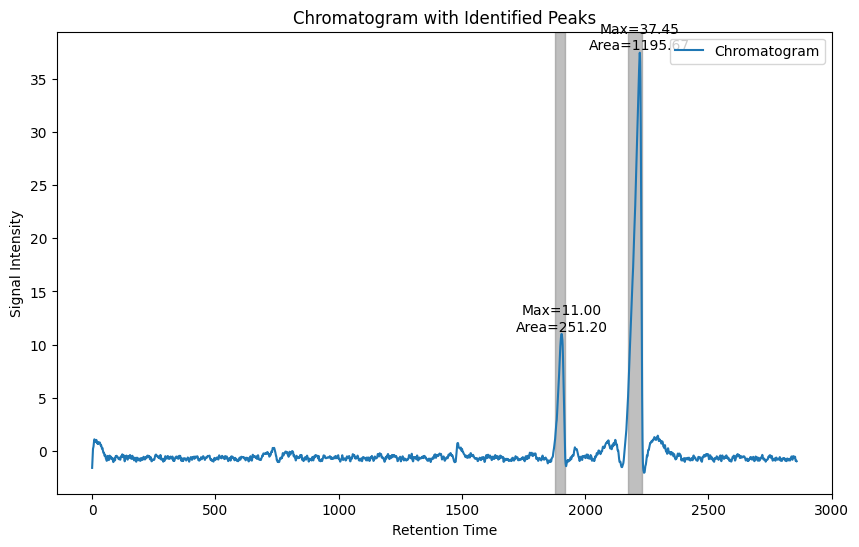

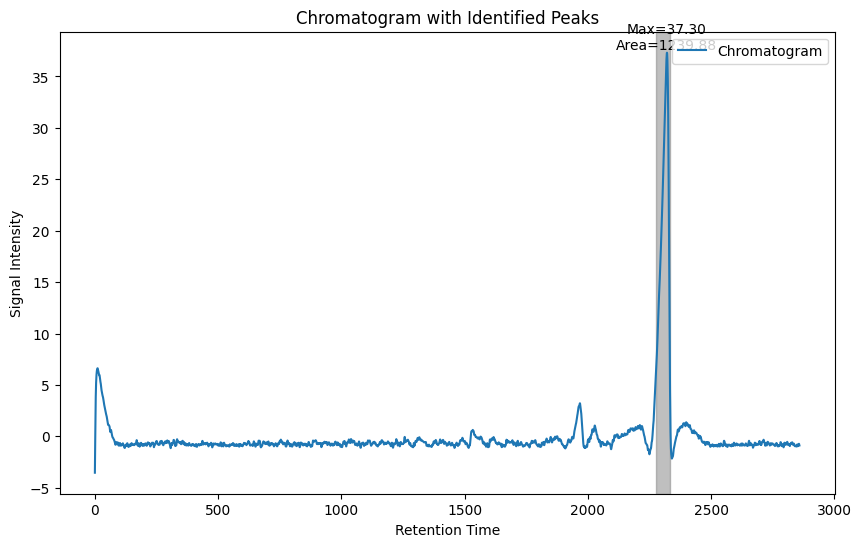

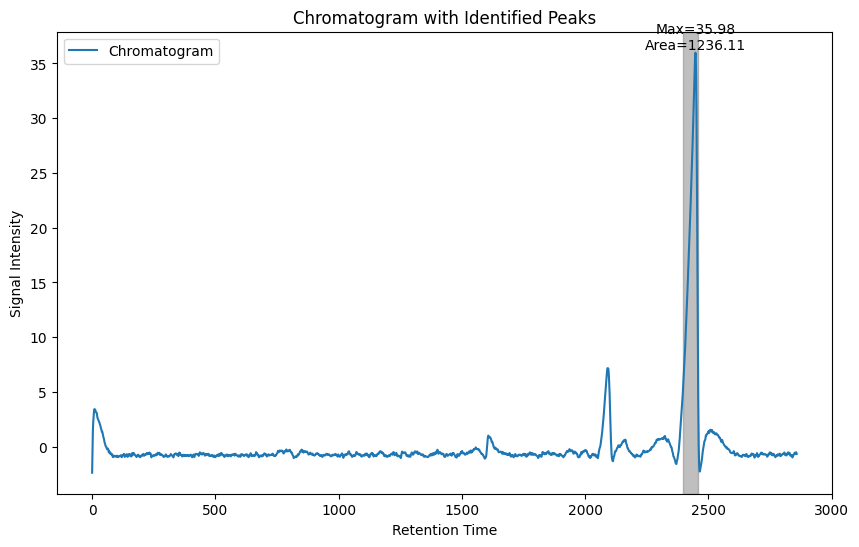

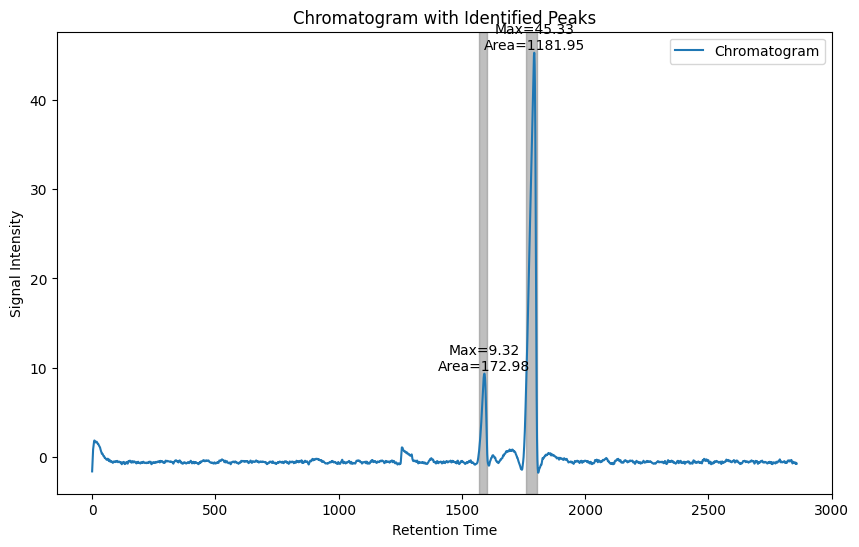

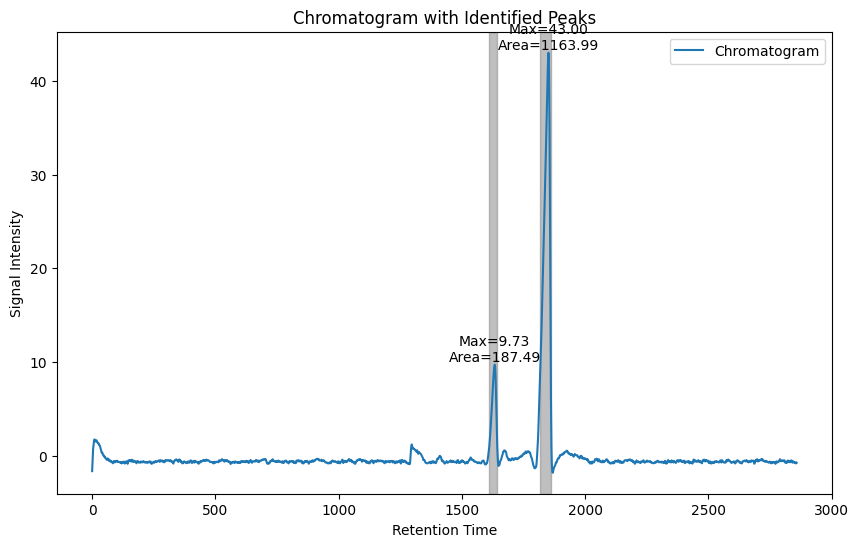

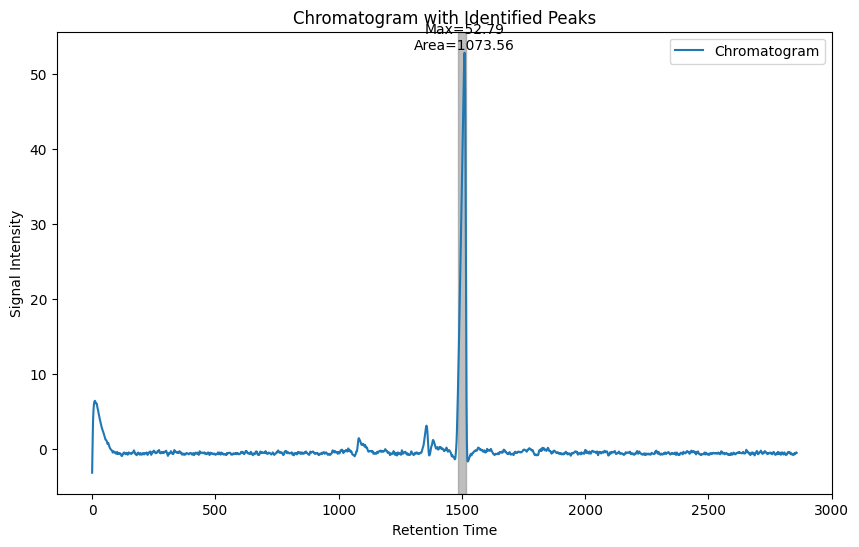

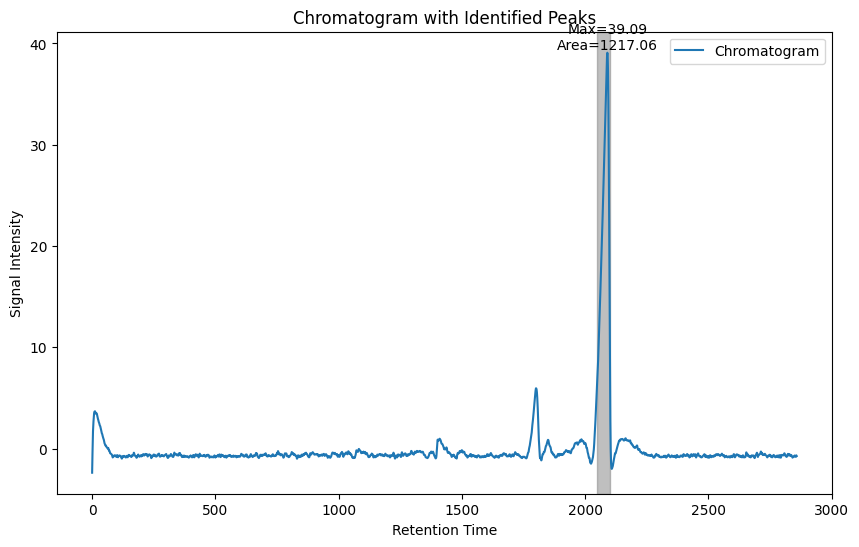

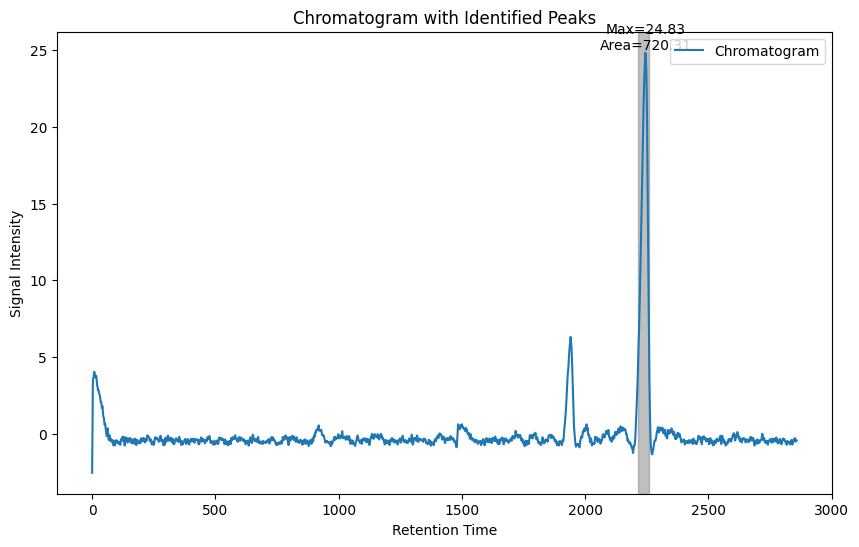

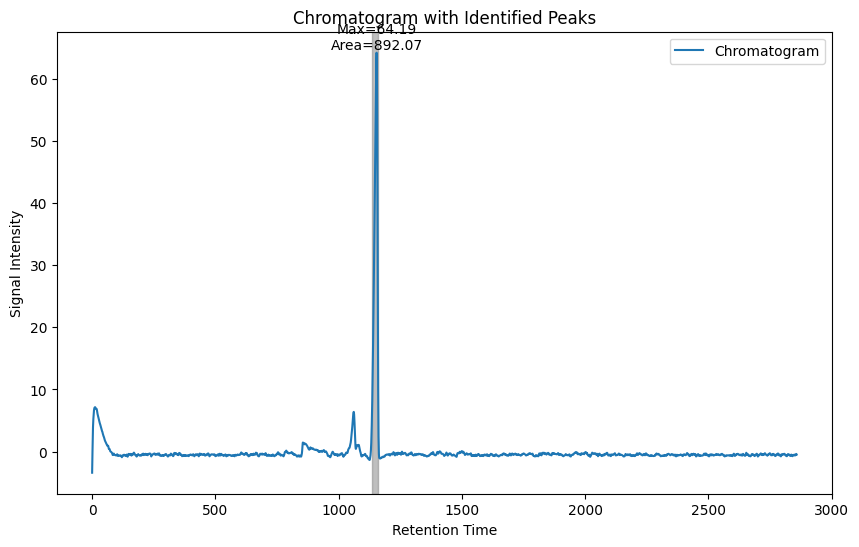

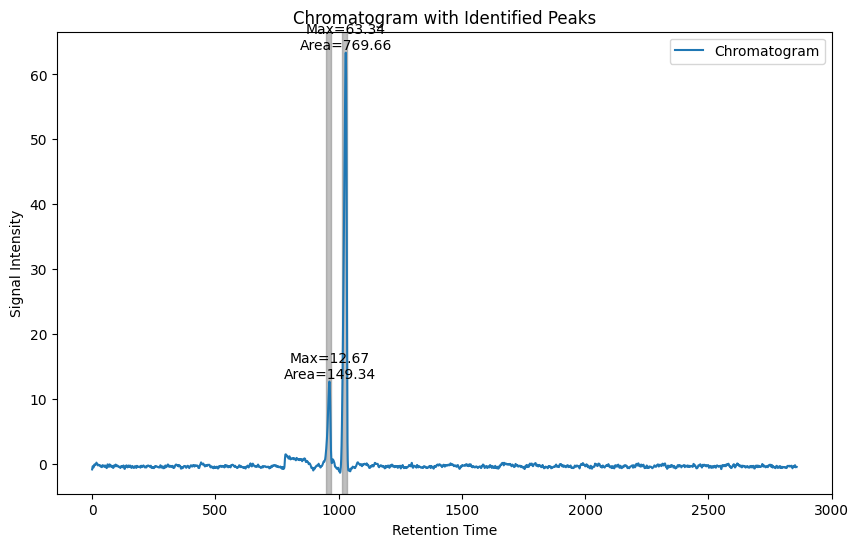

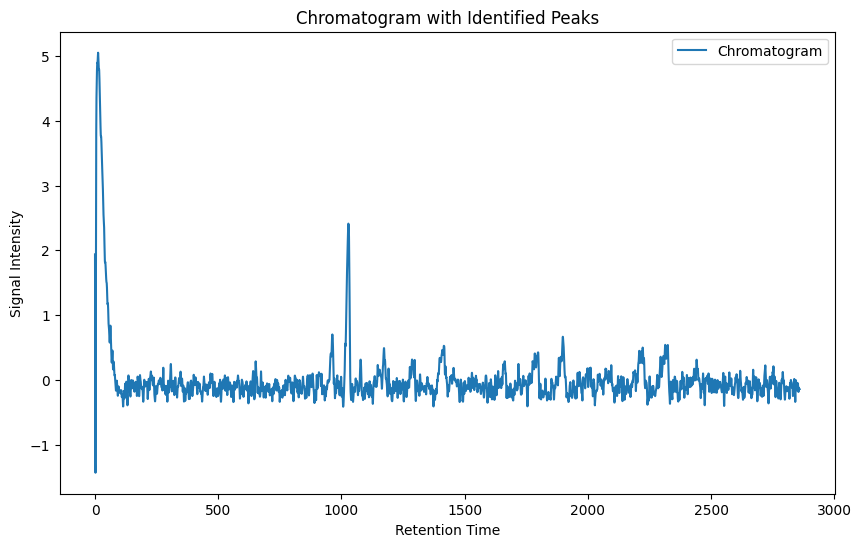

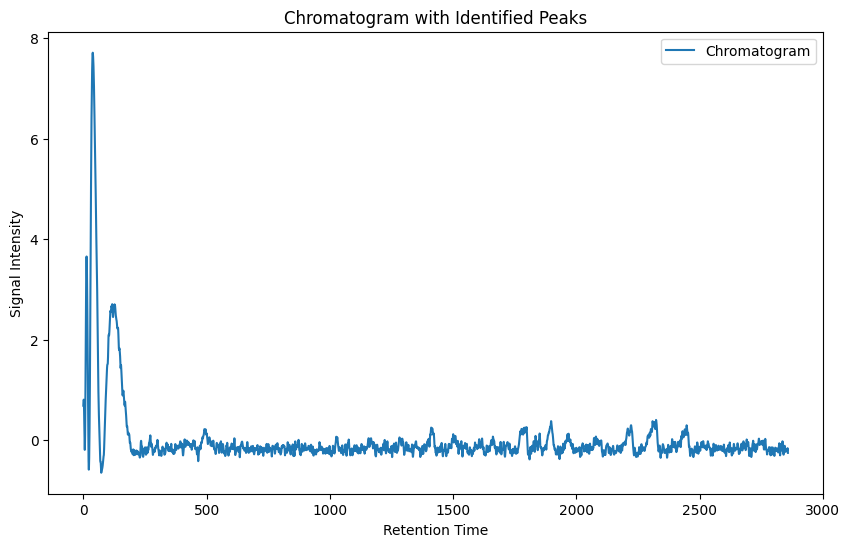

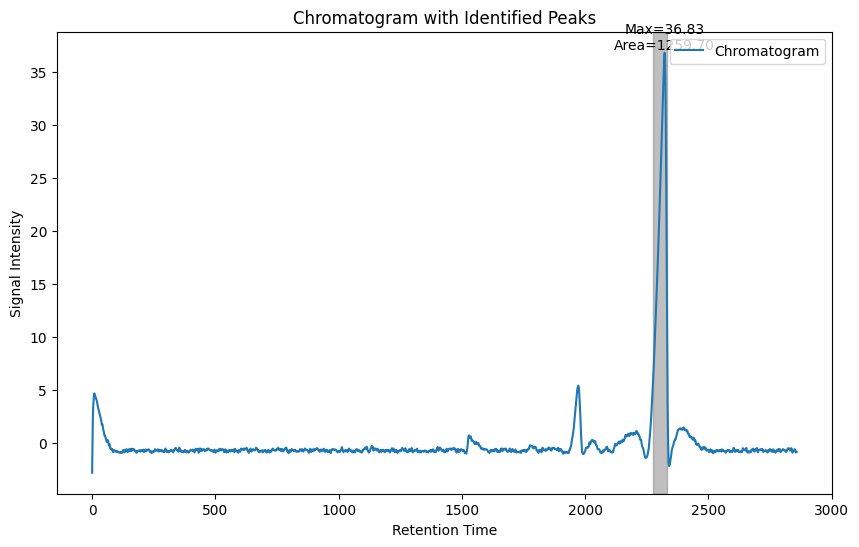

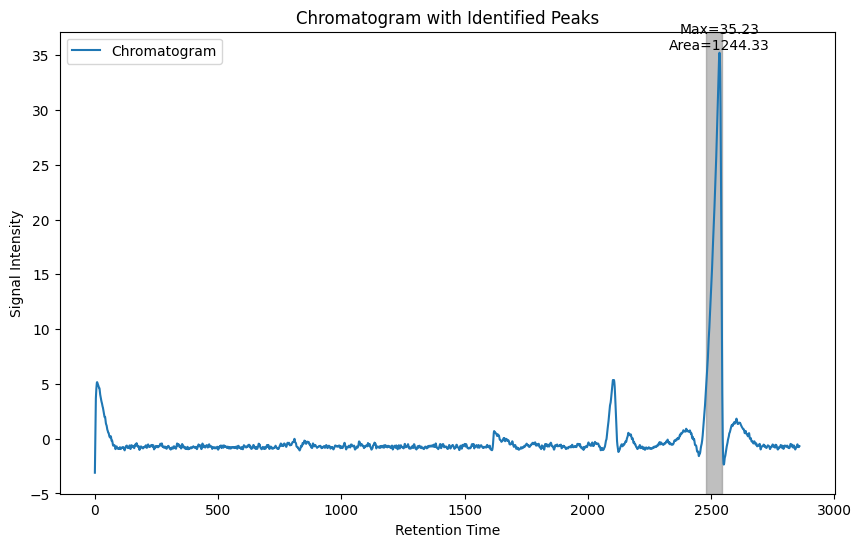

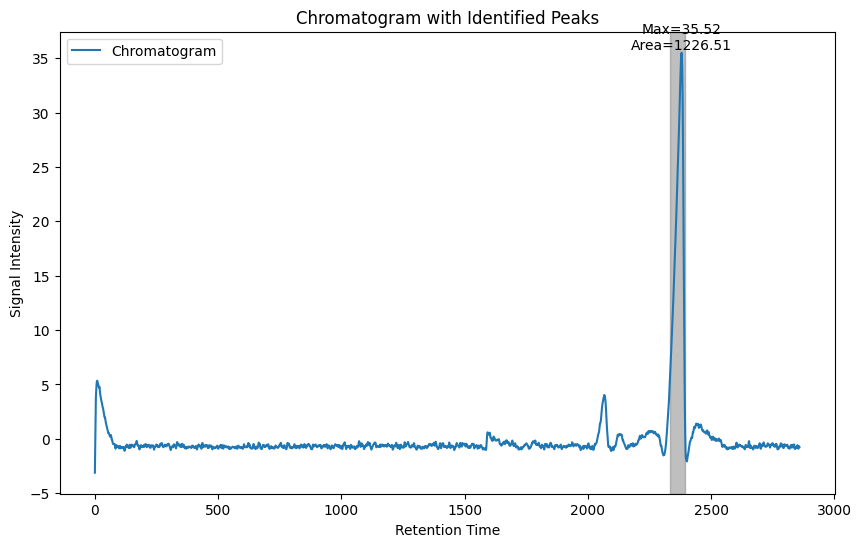

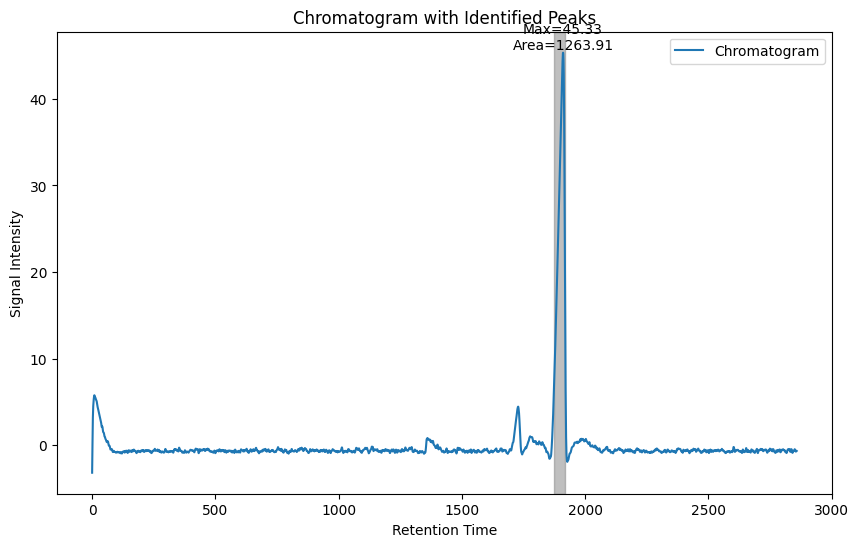

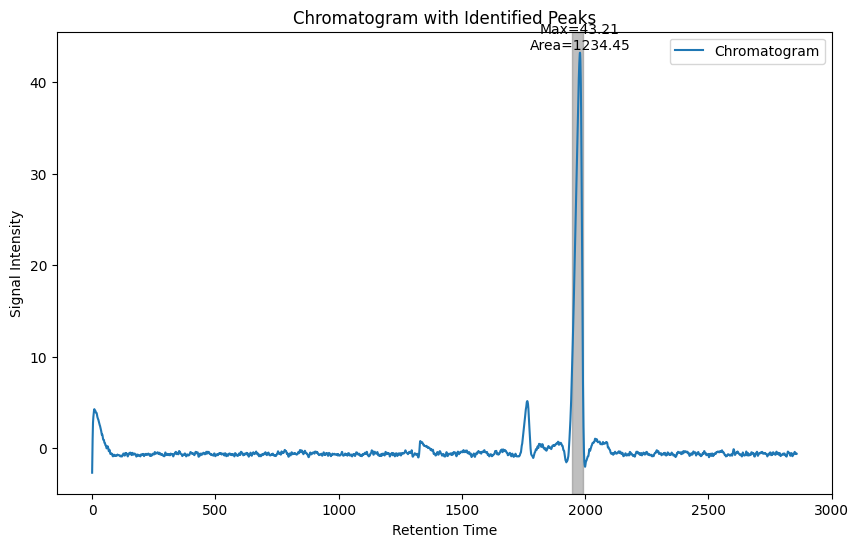

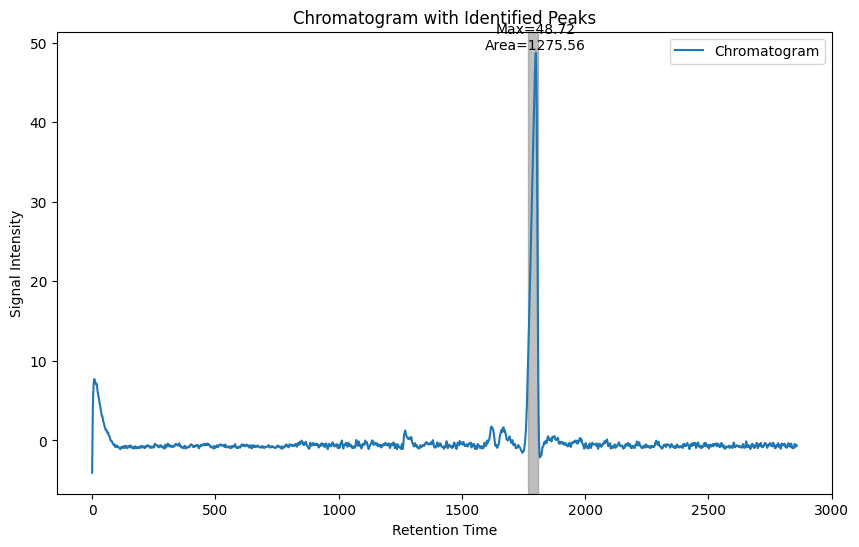

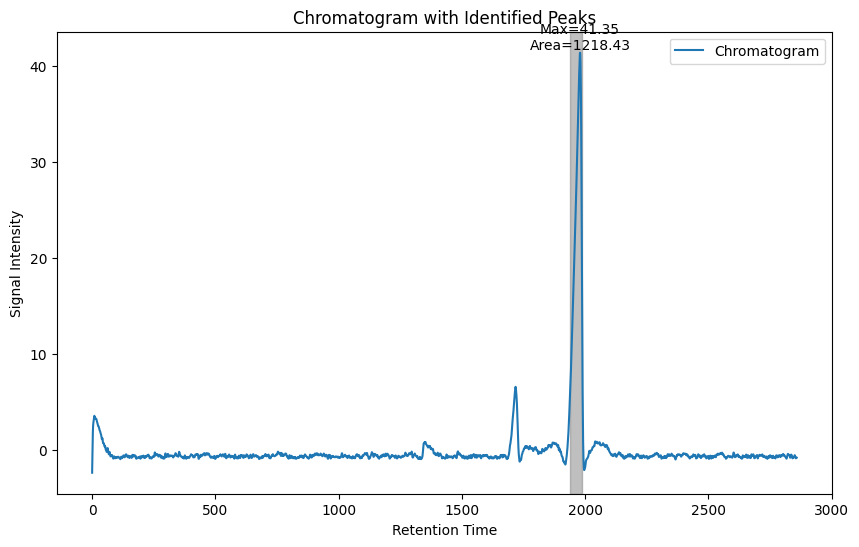

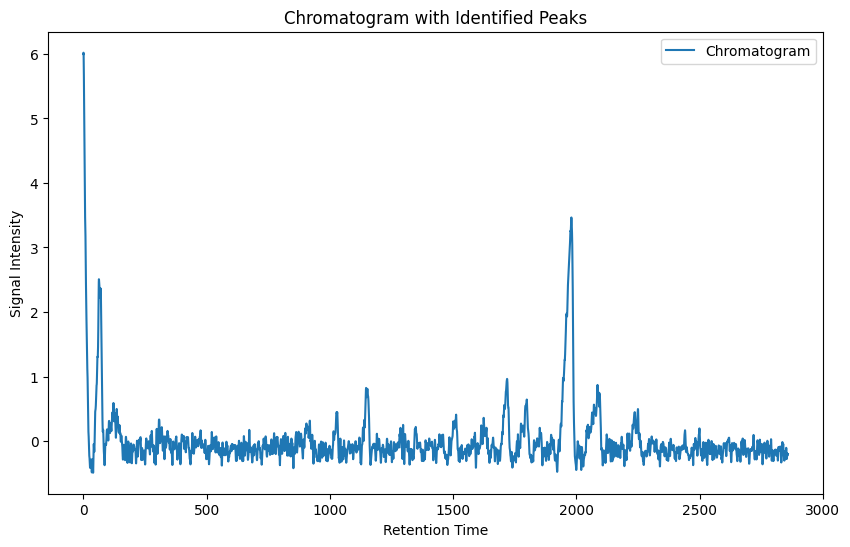

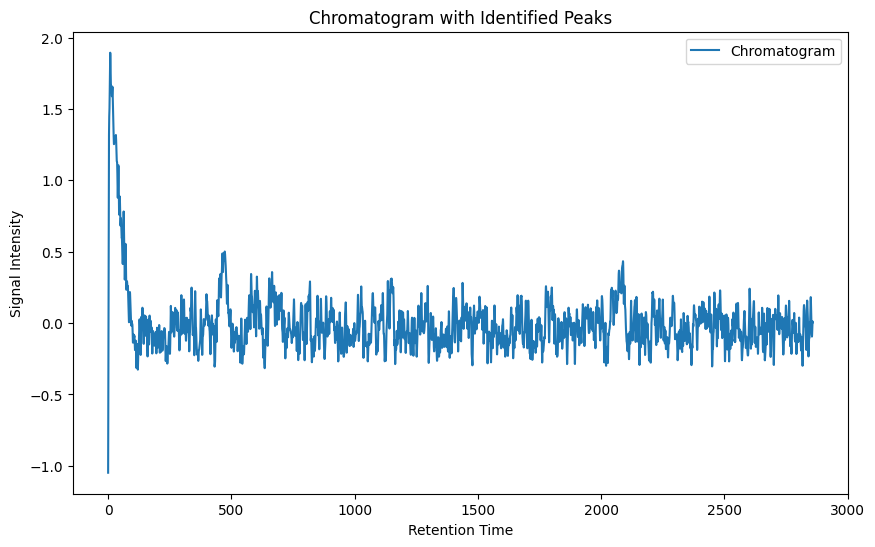

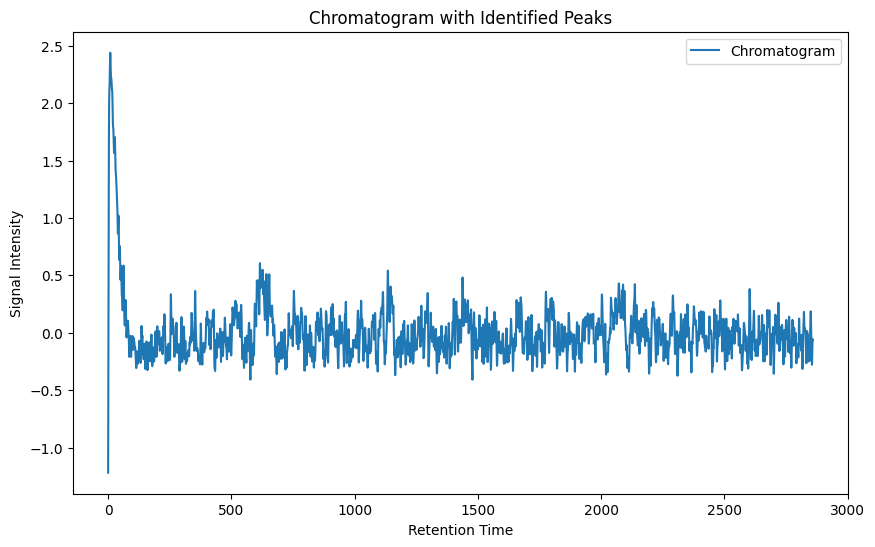

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import trapz

def analyze_chromatogram(x, y, prominence=10, width=20, rel_height=0.8):
    # Find the peaks in the chromatography data
    peaks, properties = find_peaks(y, prominence=prominence, width=width)

    # Calculate peak widths
    results_half = peak_widths(y, peaks, rel_height=rel_height)

    peak_info_list = []
    for i in range(len(peaks)):
        peak_index = peaks[i]
        left_ips = int(results_half[2][i])
        right_ips = int(results_half[3][i])
        peak_x = x[peak_index]
        peak_y = y[peak_index]
        
        # Calculate the integral of the peak (assuming evenly spaced data)
        peak_integral = trapz(y[left_ips:right_ips], x[left_ips:right_ips])

        # Store peak information in a dictionary
        peak_info = {
            "peak_position": peak_x,
            "peak_boundaries": (x[left_ips], x[right_ips]),
            "peak_maximum": peak_y,
            "peak_area": peak_integral
        }
        peak_info_list.append(peak_info)

    # Create a plot of the chromatogram with identified peaks
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Chromatogram')

    for peak_info in peak_info_list:
        peak_x = peak_info["peak_position"]
        peak_y = peak_info["peak_maximum"]
        left_boundary, right_boundary = peak_info["peak_boundaries"]
        peak_area = peak_info["peak_area"]

        # Highlight the peak region
        plt.axvspan(left_boundary, right_boundary, color='gray', alpha=0.5)

        # Label the peak maximum and area
        plt.text(peak_x, peak_y, f'Max={peak_y:.2f}\nArea={peak_area:.2f}', fontsize=10, ha='center', va='bottom')

    plt.xlabel('Retention Time')
    plt.ylabel('Signal Intensity')
    plt.legend()
    plt.title('Chromatogram with Identified Peaks')
    plt.show()

    return peak_info_list

# Example usage:
import string
for letter in string.ascii_uppercase[:8]:
    for i in range(1,12):
        x = processed_data1[f"{letter}{i}"]["x"]
        y = processed_data1[f"{letter}{i}"]["baseline_free_y"]
        peak_info = analyze_chromatogram(x, y)
